# Classification on Botnet DGA Dataset

In [1]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pennylane as qml
from pennylane import numpy as np

from datetime import datetime
import os
import pickle
import time

import qiskit
import qiskit.providers.aer.noise as noise

from qiskit import QuantumCircuit, execute
from qiskit import IBMQ, Aer
from qiskit.visualization import plot_histogram
from qiskit.providers.aer.noise import NoiseModel

In [2]:
#IBMQ.save_account('412323e770fb2ee81fb9b79d3effe940d0a7f72c3be198a65f580a20b38b00a607ad8c8a9b5322116fc1aee89be55463fe87e7a43da6af415bbaa95236fca521')

## Experiment Settings

In [3]:
import random as python_random
SEED = 123
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
python_random.seed(SEED)
tf.random.set_seed(SEED)

n_qubits = 2
# dev = qml.device("default.mixed", wires=n_qubits)


#dev = qml.device('qiskit.aer', wires=n_qubits)


# Error probabilities
#prob_1 = 0.001  # 1-qubit gate
#prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
#error_1 = noise.depolarizing_error(prob_1, 1)
#error_2 = noise.depolarizing_error(prob_2, 2)

# Add errors to noise model
#noise_model = noise.NoiseModel()
#noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
#noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Create a PennyLane device
# dev = qml.device('qiskit.aer', wires=n_qubits, noise_model=noise_model)


# Build noise model from backend properties
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_athens')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

dev = qml.device('qiskit.aer', wires=n_qubits, backend='qasm_simulator', 
                 coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model)
#                 backend_options={"validation_threshold": 1e-6})


n_layers = 1 #6
num_data = 1000  #1803333
EPOCHS = 10000
BATCH_SIZE = 50 #2048


weight_shapes = {"weights": (n_layers, n_qubits)}

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

now = datetime.now()
results_folder = "RESULTS5-QiskitNoisy/nd" + str(num_data) + "_" + "nq" + str(n_qubits) + "_" + "nl" + str(n_layers) + "_" + now.strftime("%m-%d-%Y_%H-%M-%S") + "/"
print("results_folder: ",results_folder)
os.mkdir(results_folder)

f = open(results_folder + "results.txt", "a", encoding='utf-8')
f.write(results_folder + "\n")

mpl.rcParams['savefig.dpi'] = 600

results_folder:  RESULTS5-QiskitNoisy/nd1000_nq2_nl1_03-25-2021_14-04-57/


## Example of a QNode

In [4]:
@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

## Data processing and exploration

### Load csv data set

In [5]:
#raw_df = pd.read_csv("dataset/n"+str(num_data)+"_botnetdga_TRAIN.csv")
#raw_df.head()

In [6]:
#raw_df[['Entropy','REAlexa','MinREBotnets','InformationRadius','CharLength','TreeNewFeature','nGramReputation_Alexa','Class']].describe()

### Clean, split and normalize the data

In [7]:
#cleaned_df = raw_df.copy()
#cleaned_df.pop('Entropy')
#cleaned_df.pop('REAlexa')
#cleaned_df.pop('InformationRadius')

In [8]:
#train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
#train_df, val_df = train_test_split(train_df, test_size=0.2)

In [9]:
#train_labels = np.array(train_df.pop('Class'))
#val_labels = np.array(val_df.pop('Class'))
#test_labels = np.array(test_df.pop('Class'))

In [10]:
#train_features = np.array(train_df)
#val_features = np.array(val_df)
#test_features = np.array(test_df)

In [11]:
#scaler = StandardScaler()
#train_features = scaler.fit_transform(train_features)
#val_features = scaler.transform(val_features)
#test_features = scaler.transform(test_features)

In [12]:
#train_features = np.clip(train_features, -5, 5)
#val_features = np.clip(val_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

## Loads the already prepared benchmark datasets

In [13]:
test_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_features.csv") )
test_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_test_labels.csv") )

train_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_features.csv") )
train_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_train_labels.csv") )

val_features = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_features.csv") )
val_labels = np.array( pd.read_csv("benchmark-datasets/n" + str(num_data) + "_val_labels.csv") )

## Define the model and metrics 

In [14]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          n_qubits, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      qlayer,
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

In [15]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=100,
    mode='max',
    restore_best_weights=True)

In [16]:
def plot_loss(history, label, n, expId):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.savefig(results_folder + '_' + str(expId) + '_plot_loss.png', format='png')

    
def plot_metrics(history, expId):
  metrics = ['accuracy', 'loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(5,1,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    plt.savefig(results_folder + '_' + str(expId) + '_plot_metrics.png', format='png')
    
def plot_cm(labels, predictions, expId , p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  plt.savefig(results_folder + '_' + str(expId) + '_plot_cm.png', format='png')

  print('Legitimate Domain Name Detected (True Negatives): ', cm[0][0])
  print('Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives): ', cm[0][1])
  print('Botnet DGA Missed (False Negatives): ', cm[1][0])
  print('Botnet DGA Detected (True Positives): ', cm[1][1])
  print('Total Botnet DGAs: ', np.sum(cm[1]))

def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = sklearn.metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

## Checkpoint the initial weights

To make the various training runs more comparable, keep this initial model's weights in a checkpoint file, and load them into each model before training.

In [17]:
model = make_model()

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

print("initial_weights = ", initial_weights)

initial_weights =  /tmp/tmpf6kogqp_/initial_weights


# Experiments A - Hybrid Classical-Quantum DL

In [18]:
def runTheExperiments(expId, desc, model=None):
    
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ['PYTHONHASHSEED'] = '0'
    np.random.seed(SEED)
    python_random.seed(SEED)
    tf.random.set_seed(SEED)

    start_time = time.time()
    f.write("\n\n\n#" + desc + "\n")
    
    if model is None:
        model = make_model()
        model.load_weights(initial_weights)

    history = model.fit(
        train_features,
        train_labels,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[early_stopping],
        validation_data=(val_features, val_labels))

    #model.save(results_folder + 'model_' + str(expId))
    #with open(results_folder + 'history_' + str(expId), 'wb') as file_pi:
    #    pickle.dump(history.history, file_pi)

    train_predictions = model.predict(train_features, batch_size=BATCH_SIZE)
    test_predictions = model.predict(test_features, batch_size=BATCH_SIZE)


    plot_loss(history, "history", 0, expId=expId)

    plot_metrics(history, expId=expId)

    baseline_results = model.evaluate(test_features, test_labels,
                                      batch_size=BATCH_SIZE, verbose=0)
    for name, value in zip(model.metrics_names, baseline_results):
      print(name, ': ', value)
      f.write(name + ' : \t' + str(value) + "\n")
    print()
    plot_cm(test_labels, test_predictions, expId=expId)

    plot_roc("Train", train_labels, train_predictions, color=colors[0])
    plot_roc("Test", test_labels, test_predictions, color=colors[0], linestyle='--')
    plt.legend(loc='lower right')
    plt.savefig(results_folder + '_' + str(expId) + '_plot_roc.png', format='png')
    
    f.write("--- %s seconds ---" % (time.time() - start_time))  
    f.write("\n\n")
    f.write(qnode.draw())
    f.flush()
    
    tf.keras.utils.plot_model(
    model, to_file=results_folder+'model'+ str(expId) + '.png', show_shapes=True, show_dtype=True,
    show_layer_names=True, rankdir='TB', expand_nested=True, dpi=600
    )
        
    return model, history
    

## AngleEmbedding

Epoch 1/10000
13/13 [==============================] - 458s 36s/step - loss: 0.7158 - tp: 112.7857 - fp: 141.6429 - tn: 48.8571 - fn: 66.5714 - accuracy: 0.4249 - precision: 0.4293 - recall: 0.6130 - auc: 0.4845 - val_loss: 0.7649 - val_tp: 30.0000 - val_fp: 49.0000 - val_tn: 24.0000 - val_fn: 56.0000 - val_accuracy: 0.3396 - val_precision: 0.3797 - val_recall: 0.3488 - val_auc: 0.2998
Epoch 2/10000
13/13 [==============================] - 461s 36s/step - loss: 0.7244 - tp: 97.8571 - fp: 125.5714 - tn: 66.3571 - fn: 80.0714 - accuracy: 0.4438 - precision: 0.4335 - recall: 0.5663 - auc: 0.4870 - val_loss: 0.7585 - val_tp: 23.0000 - val_fp: 40.0000 - val_tn: 33.0000 - val_fn: 63.0000 - val_accuracy: 0.3522 - val_precision: 0.3651 - val_recall: 0.2674 - val_auc: 0.2667
Epoch 3/10000
13/13 [==============================] - 462s 36s/step - loss: 0.7329 - tp: 73.2857 - fp: 87.0000 - tn: 106.7857 - fn: 102.7857 - accuracy: 0.4740 - precision: 0.4318 - recall: 0.4089 - auc: 0.4206 - val_loss:

13/13 [==============================] - 466s 36s/step - loss: 0.6482 - tp: 67.3571 - fp: 8.8571 - tn: 178.7143 - fn: 114.9286 - accuracy: 0.6681 - precision: 0.8944 - recall: 0.3801 - auc: 0.7535 - val_loss: 0.6649 - val_tp: 32.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 54.0000 - val_accuracy: 0.6415 - val_precision: 0.9143 - val_recall: 0.3721 - val_auc: 0.8266
Epoch 23/10000
13/13 [==============================] - 465s 36s/step - loss: 0.6525 - tp: 58.8571 - fp: 5.7143 - tn: 182.7143 - fn: 122.5714 - accuracy: 0.6504 - precision: 0.9252 - recall: 0.3217 - auc: 0.7240 - val_loss: 0.6606 - val_tp: 38.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 48.0000 - val_accuracy: 0.6792 - val_precision: 0.9268 - val_recall: 0.4419 - val_auc: 0.8285
Epoch 24/10000
13/13 [==============================] - 465s 36s/step - loss: 0.6402 - tp: 63.4286 - fp: 10.3571 - tn: 183.3571 - fn: 112.7143 - accuracy: 0.6746 - precision: 0.8673 - recall: 0.3794 - auc: 0.7076 - val_loss: 0.6612 - val_t

13/13 [==============================] - 466s 36s/step - loss: 0.6209 - tp: 64.0714 - fp: 5.7857 - tn: 186.0000 - fn: 114.0000 - accuracy: 0.6670 - precision: 0.9316 - recall: 0.3308 - auc: 0.7338 - val_loss: 0.6172 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.8352
Epoch 44/10000
13/13 [==============================] - 466s 36s/step - loss: 0.5925 - tp: 72.1429 - fp: 10.5000 - tn: 182.7857 - fn: 104.4286 - accuracy: 0.6959 - precision: 0.8576 - recall: 0.4197 - auc: 0.7647 - val_loss: 0.6151 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8374
Epoch 45/10000
13/13 [==============================] - 466s 36s/step - loss: 0.6193 - tp: 74.3571 - fp: 11.6429 - tn: 179.6429 - fn: 104.2143 - accuracy: 0.6810 - precision: 0.8595 - recall: 0.4094 - auc: 0.7103 - val_loss: 0.6146 - val_

13/13 [==============================] - 468s 36s/step - loss: 0.5940 - tp: 78.6429 - fp: 7.8571 - tn: 183.7857 - fn: 99.5714 - accuracy: 0.7010 - precision: 0.9278 - recall: 0.4206 - auc: 0.7332 - val_loss: 0.5874 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8473
Epoch 65/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5908 - tp: 76.3571 - fp: 10.2857 - tn: 181.2857 - fn: 101.9286 - accuracy: 0.6997 - precision: 0.8986 - recall: 0.4245 - auc: 0.7596 - val_loss: 0.5851 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8479
Epoch 66/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5628 - tp: 83.8571 - fp: 8.5000 - tn: 184.1429 - fn: 93.3571 - accuracy: 0.7396 - precision: 0.9205 - recall: 0.4950 - auc: 0.7678 - val_loss: 0.5825 - val_tp:

13/13 [==============================] - 466s 36s/step - loss: 0.5720 - tp: 81.7857 - fp: 9.0000 - tn: 184.6429 - fn: 94.4286 - accuracy: 0.7198 - precision: 0.9052 - recall: 0.4514 - auc: 0.7361 - val_loss: 0.5665 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8703
Epoch 86/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5650 - tp: 89.1429 - fp: 9.9286 - tn: 176.0000 - fn: 94.7857 - accuracy: 0.7106 - precision: 0.8958 - recall: 0.4814 - auc: 0.7328 - val_loss: 0.5664 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8510
Epoch 87/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5814 - tp: 76.4286 - fp: 10.2143 - tn: 179.4286 - fn: 103.7857 - accuracy: 0.6944 - precision: 0.8788 - recall: 0.4360 - auc: 0.7441 - val_loss: 0.5641 - val_tp:

13/13 [==============================] - 467s 36s/step - loss: 0.5501 - tp: 94.5714 - fp: 8.1429 - tn: 179.7143 - fn: 87.4286 - accuracy: 0.7432 - precision: 0.9239 - recall: 0.5304 - auc: 0.7649 - val_loss: 0.5524 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8766
Epoch 107/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5707 - tp: 90.2857 - fp: 8.1429 - tn: 180.8571 - fn: 90.5714 - accuracy: 0.7332 - precision: 0.9170 - recall: 0.4962 - auc: 0.7225 - val_loss: 0.5536 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8606
Epoch 108/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5766 - tp: 88.2143 - fp: 10.3571 - tn: 179.2143 - fn: 92.0714 - accuracy: 0.7225 - precision: 0.8750 - recall: 0.5019 - auc: 0.7408 - val_loss: 0.5580 - val_tp

13/13 [==============================] - 468s 36s/step - loss: 0.5607 - tp: 91.2143 - fp: 13.3571 - tn: 173.3571 - fn: 91.9286 - accuracy: 0.7204 - precision: 0.8802 - recall: 0.5168 - auc: 0.7616 - val_loss: 0.5451 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.8588
Epoch 128/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5636 - tp: 90.0714 - fp: 10.4286 - tn: 179.8571 - fn: 89.5000 - accuracy: 0.7255 - precision: 0.8949 - recall: 0.5016 - auc: 0.7511 - val_loss: 0.5447 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.8538
Epoch 129/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5633 - tp: 91.6429 - fp: 9.0714 - tn: 175.4286 - fn: 93.7143 - accuracy: 0.7226 - precision: 0.9229 - recall: 0.5024 - auc: 0.7741 - val_loss: 0.5418 - val_t

13/13 [==============================] - 469s 36s/step - loss: 0.5390 - tp: 97.7143 - fp: 10.2143 - tn: 181.4286 - fn: 80.5000 - accuracy: 0.7519 - precision: 0.8990 - recall: 0.5474 - auc: 0.7598 - val_loss: 0.5376 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8590
Epoch 149/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5805 - tp: 91.4286 - fp: 11.9286 - tn: 174.7143 - fn: 91.7857 - accuracy: 0.7002 - precision: 0.8699 - recall: 0.4760 - auc: 0.7235 - val_loss: 0.5343 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.8670
Epoch 150/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5266 - tp: 93.3571 - fp: 9.5000 - tn: 187.0714 - fn: 79.9286 - accuracy: 0.7608 - precision: 0.9011 - recall: 0.5447 - auc: 0.7514 - val_loss: 0.5357 - val_t

13/13 [==============================] - 468s 36s/step - loss: 0.5454 - tp: 93.5000 - fp: 7.8571 - tn: 183.1429 - fn: 85.3571 - accuracy: 0.7447 - precision: 0.9344 - recall: 0.5157 - auc: 0.7935 - val_loss: 0.5298 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.8788
Epoch 170/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5368 - tp: 95.7143 - fp: 12.3571 - tn: 182.0000 - fn: 79.7857 - accuracy: 0.7488 - precision: 0.8675 - recall: 0.5461 - auc: 0.7464 - val_loss: 0.5266 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.8955
Epoch 171/10000
13/13 [==============================] - 466s 36s/step - loss: 0.5113 - tp: 94.6429 - fp: 7.7143 - tn: 186.7857 - fn: 80.7143 - accuracy: 0.7722 - precision: 0.9257 - recall: 0.5630 - auc: 0.7865 - val_loss: 0.5283 - val_tp

13/13 [==============================] - 469s 36s/step - loss: 0.5162 - tp: 95.2857 - fp: 11.8571 - tn: 185.2857 - fn: 77.4286 - accuracy: 0.7621 - precision: 0.8891 - recall: 0.5564 - auc: 0.7816 - val_loss: 0.5236 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.8910
Epoch 191/10000
13/13 [==============================] - 467s 36s/step - loss: 0.5117 - tp: 99.3571 - fp: 11.5714 - tn: 181.4286 - fn: 77.5000 - accuracy: 0.7678 - precision: 0.8932 - recall: 0.5832 - auc: 0.7819 - val_loss: 0.5197 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9010
Epoch 192/10000
13/13 [==============================] - 467s 36s/step - loss: 0.4985 - tp: 103.2857 - fp: 8.7857 - tn: 185.5714 - fn: 72.2143 - accuracy: 0.7847 - precision: 0.9339 - recall: 0.5829 - auc: 0.8020 - val_loss: 0.5167 - val_

13/13 [==============================] - 471s 36s/step - loss: 0.5106 - tp: 100.2143 - fp: 4.2143 - tn: 186.9286 - fn: 78.5000 - accuracy: 0.7677 - precision: 0.9622 - recall: 0.5402 - auc: 0.7961 - val_loss: 0.5158 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9079
Epoch 212/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5368 - tp: 93.0714 - fp: 13.6429 - tn: 179.7857 - fn: 83.3571 - accuracy: 0.7415 - precision: 0.8773 - recall: 0.5361 - auc: 0.7418 - val_loss: 0.5152 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9249
Epoch 213/10000
13/13 [==============================] - 469s 36s/step - loss: 0.5268 - tp: 105.4286 - fp: 11.2143 - tn: 180.0714 - fn: 73.1429 - accuracy: 0.7676 - precision: 0.8983 - recall: 0.5787 - auc: 0.7438 - val_loss: 0.5131 - val

13/13 [==============================] - 468s 36s/step - loss: 0.5078 - tp: 95.0714 - fp: 11.1429 - tn: 186.0714 - fn: 77.5714 - accuracy: 0.7678 - precision: 0.8973 - recall: 0.5631 - auc: 0.7681 - val_loss: 0.5108 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9194
Epoch 233/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5463 - tp: 91.5714 - fp: 10.8571 - tn: 180.7857 - fn: 86.6429 - accuracy: 0.7354 - precision: 0.8872 - recall: 0.5070 - auc: 0.7384 - val_loss: 0.5082 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9208
Epoch 234/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5211 - tp: 102.2143 - fp: 7.7143 - tn: 185.7857 - fn: 74.1429 - accuracy: 0.7831 - precision: 0.9241 - recall: 0.5795 - auc: 0.7623 - val_loss: 0.5071 - val_

13/13 [==============================] - 468s 36s/step - loss: 0.4999 - tp: 101.7143 - fp: 7.1429 - tn: 186.6429 - fn: 74.3571 - accuracy: 0.7787 - precision: 0.9258 - recall: 0.5745 - auc: 0.7660 - val_loss: 0.5033 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9309
Epoch 254/10000
13/13 [==============================] - 469s 36s/step - loss: 0.4775 - tp: 111.3571 - fp: 6.9286 - tn: 183.0000 - fn: 68.5714 - accuracy: 0.8000 - precision: 0.9380 - recall: 0.6232 - auc: 0.8070 - val_loss: 0.5068 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9270
Epoch 255/10000
13/13 [==============================] - 470s 36s/step - loss: 0.4744 - tp: 109.6429 - fp: 6.4286 - tn: 183.1429 - fn: 70.6429 - accuracy: 0.7964 - precision: 0.9530 - recall: 0.6106 - auc: 0.7919 - val_loss: 0.5054 - val_

13/13 [==============================] - 469s 36s/step - loss: 0.4756 - tp: 100.2857 - fp: 9.3571 - tn: 189.3571 - fn: 70.8571 - accuracy: 0.8006 - precision: 0.9001 - recall: 0.6211 - auc: 0.7990 - val_loss: 0.4994 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9337
Epoch 275/10000
13/13 [==============================] - 469s 36s/step - loss: 0.4838 - tp: 110.3571 - fp: 8.7857 - tn: 182.2857 - fn: 68.4286 - accuracy: 0.7975 - precision: 0.9268 - recall: 0.6323 - auc: 0.7970 - val_loss: 0.4988 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9381
Epoch 276/10000
13/13 [==============================] - 468s 36s/step - loss: 0.5159 - tp: 107.7143 - fp: 7.1429 - tn: 182.0714 - fn: 72.9286 - accuracy: 0.7751 - precision: 0.9341 - recall: 0.5837 - auc: 0.7525 - val_loss: 0.4980 - val_

13/13 [==============================] - 446s 34s/step - loss: 0.4847 - tp: 107.8571 - fp: 10.5000 - tn: 178.6429 - fn: 72.8571 - accuracy: 0.7762 - precision: 0.9040 - recall: 0.6034 - auc: 0.8060 - val_loss: 0.4927 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9442
Epoch 296/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4877 - tp: 113.0000 - fp: 10.4286 - tn: 180.8571 - fn: 65.5714 - accuracy: 0.7909 - precision: 0.9102 - recall: 0.6320 - auc: 0.7903 - val_loss: 0.4972 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9400
Epoch 297/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4759 - tp: 106.1429 - fp: 6.5000 - tn: 186.0714 - fn: 71.1429 - accuracy: 0.7889 - precision: 0.9463 - recall: 0.5965 - auc: 0.7932 - val_loss: 0.4940 - va

13/13 [==============================] - 447s 34s/step - loss: 0.4894 - tp: 110.1429 - fp: 7.8571 - tn: 182.5714 - fn: 69.2857 - accuracy: 0.7817 - precision: 0.9291 - recall: 0.6067 - auc: 0.7977 - val_loss: 0.4953 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9415
Epoch 317/10000
13/13 [==============================] - 446s 34s/step - loss: 0.4585 - tp: 110.2143 - fp: 1.8571 - tn: 191.9286 - fn: 65.8571 - accuracy: 0.8276 - precision: 0.9885 - recall: 0.6402 - auc: 0.8248 - val_loss: 0.4903 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9368
Epoch 318/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4848 - tp: 103.7857 - fp: 6.5714 - tn: 188.1429 - fn: 71.3571 - accuracy: 0.7879 - precision: 0.9469 - recall: 0.5892 - auc: 0.7950 - val_loss: 0.4887 - val_

13/13 [==============================] - 447s 34s/step - loss: 0.5099 - tp: 96.4286 - fp: 7.9286 - tn: 192.0000 - fn: 73.5000 - accuracy: 0.7743 - precision: 0.9125 - recall: 0.5533 - auc: 0.7455 - val_loss: 0.4918 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9389
Epoch 338/10000
13/13 [==============================] - 446s 34s/step - loss: 0.5033 - tp: 97.6429 - fp: 7.2143 - tn: 189.2143 - fn: 75.7857 - accuracy: 0.7808 - precision: 0.9399 - recall: 0.5592 - auc: 0.7617 - val_loss: 0.4854 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9438
Epoch 339/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4888 - tp: 112.2143 - fp: 8.2857 - tn: 180.3571 - fn: 69.0000 - accuracy: 0.7823 - precision: 0.9409 - recall: 0.6073 - auc: 0.7965 - val_loss: 0.4887 - val_tp

13/13 [==============================] - 449s 35s/step - loss: 0.4897 - tp: 101.4286 - fp: 5.8571 - tn: 185.2143 - fn: 77.3571 - accuracy: 0.7798 - precision: 0.9545 - recall: 0.5716 - auc: 0.7712 - val_loss: 0.4830 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9442
Epoch 359/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4762 - tp: 111.4286 - fp: 6.8571 - tn: 180.6429 - fn: 70.9286 - accuracy: 0.7874 - precision: 0.9406 - recall: 0.6087 - auc: 0.7817 - val_loss: 0.4840 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9419
Epoch 360/10000
13/13 [==============================] - 448s 34s/step - loss: 0.5272 - tp: 100.2143 - fp: 10.3571 - tn: 178.6429 - fn: 80.6429 - accuracy: 0.7504 - precision: 0.9025 - recall: 0.5500 - auc: 0.7329 - val_loss: 0.4832 - val

13/13 [==============================] - 448s 34s/step - loss: 0.4785 - tp: 107.7857 - fp: 4.9286 - tn: 187.2143 - fn: 69.9286 - accuracy: 0.7988 - precision: 0.9594 - recall: 0.6118 - auc: 0.7780 - val_loss: 0.4837 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9461
Epoch 380/10000
13/13 [==============================] - 445s 34s/step - loss: 0.5041 - tp: 98.0714 - fp: 7.7857 - tn: 186.7857 - fn: 77.2143 - accuracy: 0.7687 - precision: 0.9181 - recall: 0.5578 - auc: 0.7589 - val_loss: 0.4819 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9470
Epoch 381/10000
13/13 [==============================] - 445s 34s/step - loss: 0.4541 - tp: 110.6429 - fp: 5.2857 - tn: 188.8571 - fn: 65.0714 - accuracy: 0.8109 - precision: 0.9527 - recall: 0.6366 - auc: 0.8088 - val_loss: 0.4825 - val_t

13/13 [==============================] - 447s 34s/step - loss: 0.4944 - tp: 104.2857 - fp: 7.0714 - tn: 183.1429 - fn: 75.3571 - accuracy: 0.7675 - precision: 0.9354 - recall: 0.5735 - auc: 0.7835 - val_loss: 0.4728 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9460
Epoch 401/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4589 - tp: 105.6429 - fp: 6.1429 - tn: 187.4286 - fn: 70.6429 - accuracy: 0.7996 - precision: 0.9512 - recall: 0.6112 - auc: 0.8329 - val_loss: 0.4725 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9439
Epoch 402/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4988 - tp: 105.7857 - fp: 6.7143 - tn: 184.8571 - fn: 72.5000 - accuracy: 0.7771 - precision: 0.9448 - recall: 0.5765 - auc: 0.7495 - val_loss: 0.4768 - val_

13/13 [==============================] - 448s 35s/step - loss: 0.4641 - tp: 106.5714 - fp: 5.0714 - tn: 189.7857 - fn: 68.4286 - accuracy: 0.8074 - precision: 0.9578 - recall: 0.6134 - auc: 0.7976 - val_loss: 0.4764 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9466
Epoch 422/10000
13/13 [==============================] - 448s 35s/step - loss: 0.4843 - tp: 109.8571 - fp: 8.5714 - tn: 183.4286 - fn: 68.0000 - accuracy: 0.7859 - precision: 0.9064 - recall: 0.6088 - auc: 0.7963 - val_loss: 0.4777 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9407
Epoch 423/10000
13/13 [==============================] - 447s 34s/step - loss: 0.5295 - tp: 100.3571 - fp: 6.9286 - tn: 176.7143 - fn: 85.8571 - accuracy: 0.7348 - precision: 0.9297 - recall: 0.5305 - auc: 0.7703 - val_loss: 0.4719 - val_

13/13 [==============================] - 447s 34s/step - loss: 0.5061 - tp: 99.4286 - fp: 6.9286 - tn: 182.1429 - fn: 81.3571 - accuracy: 0.7585 - precision: 0.9328 - recall: 0.5421 - auc: 0.7493 - val_loss: 0.4749 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9486
Epoch 443/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4748 - tp: 111.0000 - fp: 9.1429 - tn: 182.5000 - fn: 67.2143 - accuracy: 0.7853 - precision: 0.9132 - recall: 0.6201 - auc: 0.8204 - val_loss: 0.4763 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9454
Epoch 444/10000
13/13 [==============================] - 446s 34s/step - loss: 0.4710 - tp: 103.9286 - fp: 8.4286 - tn: 187.1429 - fn: 70.3571 - accuracy: 0.7965 - precision: 0.9249 - recall: 0.6151 - auc: 0.7750 - val_loss: 0.4762 - val_t

13/13 [==============================] - 446s 34s/step - loss: 0.4802 - tp: 98.8571 - fp: 4.0000 - tn: 188.2857 - fn: 78.7143 - accuracy: 0.7821 - precision: 0.9662 - recall: 0.5667 - auc: 0.7668 - val_loss: 0.4681 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9466
Epoch 464/10000
13/13 [==============================] - 446s 34s/step - loss: 0.4795 - tp: 106.4286 - fp: 7.7857 - tn: 180.7857 - fn: 74.8571 - accuracy: 0.7788 - precision: 0.9309 - recall: 0.5934 - auc: 0.7985 - val_loss: 0.4694 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9437
Epoch 465/10000
13/13 [==============================] - 448s 35s/step - loss: 0.4389 - tp: 115.5000 - fp: 6.5000 - tn: 187.0714 - fn: 60.7857 - accuracy: 0.8232 - precision: 0.9475 - recall: 0.6594 - auc: 0.8160 - val_loss: 0.4701 - val_t

13/13 [==============================] - 447s 34s/step - loss: 0.4955 - tp: 109.8571 - fp: 6.8571 - tn: 172.7143 - fn: 80.4286 - accuracy: 0.7603 - precision: 0.9435 - recall: 0.5781 - auc: 0.7726 - val_loss: 0.4655 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9517
Epoch 485/10000
13/13 [==============================] - 447s 34s/step - loss: 0.4782 - tp: 111.5714 - fp: 5.8571 - tn: 184.5714 - fn: 67.8571 - accuracy: 0.7928 - precision: 0.9437 - recall: 0.6033 - auc: 0.7779 - val_loss: 0.4684 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9506
Epoch 486/10000
13/13 [==============================] - 448s 35s/step - loss: 0.4669 - tp: 107.1429 - fp: 8.9286 - tn: 186.7143 - fn: 67.0714 - accuracy: 0.7844 - precision: 0.9080 - recall: 0.6092 - auc: 0.8031 - val_loss: 0.4710 - val_

13/13 [==============================] - 447s 34s/step - loss: 0.4918 - tp: 110.9286 - fp: 5.3571 - tn: 178.2857 - fn: 75.2857 - accuracy: 0.7689 - precision: 0.9506 - recall: 0.5885 - auc: 0.7845 - val_loss: 0.4679 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9502
Epoch 506/10000
13/13 [==============================] - 448s 34s/step - loss: 0.4700 - tp: 111.7143 - fp: 5.5714 - tn: 184.7143 - fn: 67.8571 - accuracy: 0.7985 - precision: 0.9466 - recall: 0.6076 - auc: 0.8028 - val_loss: 0.4670 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9476
Epoch 507/10000
13/13 [==============================] - 448s 34s/step - loss: 0.4704 - tp: 109.5714 - fp: 7.3571 - tn: 186.1429 - fn: 66.7857 - accuracy: 0.7993 - precision: 0.9346 - recall: 0.6136 - auc: 0.7944 - val_loss: 0.4656 - val_

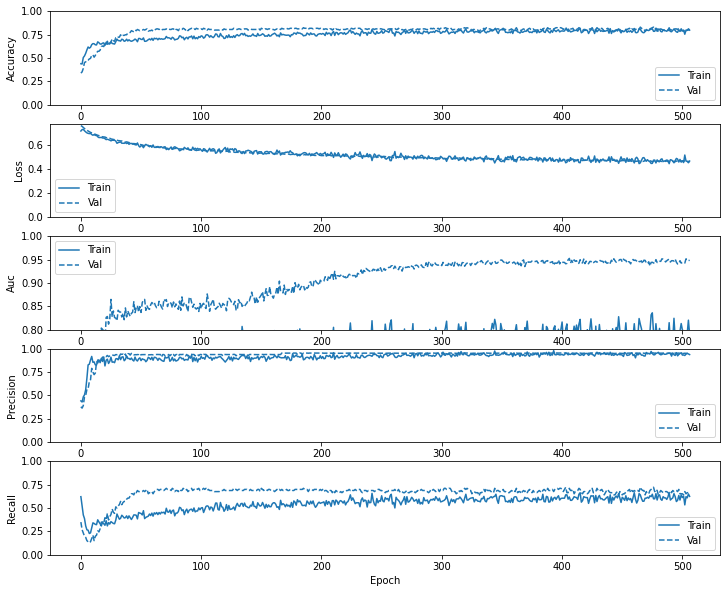

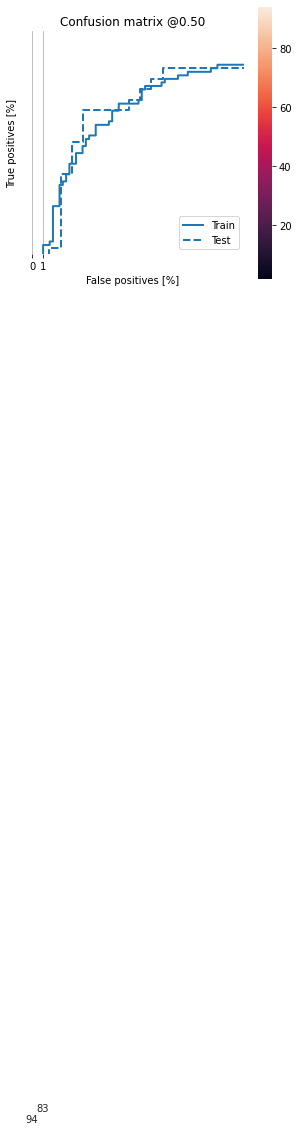

In [19]:
%%time
expId = 101
desc = str(expId) + " AngleEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) 
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_101, history_101 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 416s 32s/step - loss: 0.9647 - tp: 243.1429 - fp: 192.5000 - tn: 94.0000 - fn: 39.2143 - accuracy: 0.6144 - precision: 0.5847 - recall: 0.8518 - auc: 0.6514 - val_loss: 0.8444 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6401
Epoch 2/10000
13/13 [==============================] - 417s 32s/step - loss: 0.9565 - tp: 162.2143 - fp: 191.4286 - tn: 0.5000 - fn: 15.7143 - accuracy: 0.4316 - precision: 0.4501 - recall: 0.9104 - auc: 0.4935 - val_loss: 0.8312 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.6666
Epoch 3/10000
13/13 [==============================] - 417s 32s/step - loss: 0.9611 - tp: 155.7857 - fp: 193.4286 - tn: 0.3571 - fn: 20.2857 - accuracy: 0.4131 - precision: 0.4354 - recall: 0.8894 - auc: 0.4883 

Epoch 22/10000
13/13 [==============================] - 416s 32s/step - loss: 0.6846 - tp: 172.5000 - fp: 185.8571 - tn: 1.7143 - fn: 9.7857 - accuracy: 0.4751 - precision: 0.4872 - recall: 0.9433 - auc: 0.6004 - val_loss: 0.6320 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8156
Epoch 23/10000
13/13 [==============================] - 415s 32s/step - loss: 0.6760 - tp: 172.9286 - fp: 187.6429 - tn: 0.7857 - fn: 8.5000 - accuracy: 0.4743 - precision: 0.4845 - recall: 0.9544 - auc: 0.6277 - val_loss: 0.6280 - val_tp: 86.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.5409 - val_precision: 0.5409 - val_recall: 1.0000 - val_auc: 0.8069
Epoch 24/10000
13/13 [==============================] - 415s 32s/step - loss: 0.6805 - tp: 165.6429 - fp: 193.4286 - tn: 0.2857 - fn: 10.5000 - accuracy: 0.4513 - precision: 0.4658 - recall: 0.9348 - auc: 0.6228 

Epoch 43/10000
13/13 [==============================] - 416s 32s/step - loss: 0.6016 - tp: 63.1429 - fp: 3.2143 - tn: 188.5714 - fn: 114.9286 - accuracy: 0.6855 - precision: 0.9464 - recall: 0.3649 - auc: 0.6851 - val_loss: 0.5583 - val_tp: 64.0000 - val_fp: 10.0000 - val_tn: 63.0000 - val_fn: 22.0000 - val_accuracy: 0.7987 - val_precision: 0.8649 - val_recall: 0.7442 - val_auc: 0.8340
Epoch 44/10000
13/13 [==============================] - 416s 32s/step - loss: 0.5902 - tp: 75.0000 - fp: 9.0714 - tn: 184.2143 - fn: 101.5714 - accuracy: 0.7172 - precision: 0.8837 - recall: 0.4594 - auc: 0.7149 - val_loss: 0.5608 - val_tp: 64.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 22.0000 - val_accuracy: 0.8113 - val_precision: 0.8889 - val_recall: 0.7442 - val_auc: 0.8120
Epoch 45/10000
13/13 [==============================] - 418s 32s/step - loss: 0.6060 - tp: 69.6429 - fp: 9.2143 - tn: 182.0714 - fn: 108.9286 - accuracy: 0.6763 - precision: 0.8723 - recall: 0.3902 - auc: 0.6836 - val_loss:

13/13 [==============================] - 418s 32s/step - loss: 0.5779 - tp: 67.6429 - fp: 6.7857 - tn: 184.8571 - fn: 110.5714 - accuracy: 0.6875 - precision: 0.9141 - recall: 0.3926 - auc: 0.7540 - val_loss: 0.5429 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 25.0000 - val_accuracy: 0.7925 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.8347
Epoch 65/10000
13/13 [==============================] - 418s 32s/step - loss: 0.5972 - tp: 65.8571 - fp: 8.1429 - tn: 183.4286 - fn: 112.4286 - accuracy: 0.6734 - precision: 0.8859 - recall: 0.3682 - auc: 0.7374 - val_loss: 0.5411 - val_tp: 61.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 25.0000 - val_accuracy: 0.7925 - val_precision: 0.8841 - val_recall: 0.7093 - val_auc: 0.8412
Epoch 66/10000
13/13 [==============================] - 418s 32s/step - loss: 0.5713 - tp: 72.4286 - fp: 8.4286 - tn: 184.2143 - fn: 104.7857 - accuracy: 0.7040 - precision: 0.9040 - recall: 0.4224 - auc: 0.7414 - val_loss: 0.5454 - val_tp

13/13 [==============================] - 420s 32s/step - loss: 0.5329 - tp: 77.4286 - fp: 7.0714 - tn: 186.5714 - fn: 98.7857 - accuracy: 0.7200 - precision: 0.9206 - recall: 0.4443 - auc: 0.8086 - val_loss: 0.5157 - val_tp: 64.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 22.0000 - val_accuracy: 0.8113 - val_precision: 0.8889 - val_recall: 0.7442 - val_auc: 0.8910
Epoch 86/10000
13/13 [==============================] - 421s 32s/step - loss: 0.5397 - tp: 83.9286 - fp: 7.5714 - tn: 178.3571 - fn: 100.0000 - accuracy: 0.7086 - precision: 0.9262 - recall: 0.4579 - auc: 0.7834 - val_loss: 0.5189 - val_tp: 63.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 23.0000 - val_accuracy: 0.8050 - val_precision: 0.8873 - val_recall: 0.7326 - val_auc: 0.8724
Epoch 87/10000
13/13 [==============================] - 420s 32s/step - loss: 0.5578 - tp: 66.2857 - fp: 4.0714 - tn: 185.5714 - fn: 113.9286 - accuracy: 0.6863 - precision: 0.9470 - recall: 0.3792 - auc: 0.7530 - val_loss: 0.5127 - val_tp:

13/13 [==============================] - 422s 32s/step - loss: 0.5165 - tp: 82.5714 - fp: 9.7143 - tn: 178.1429 - fn: 99.4286 - accuracy: 0.7020 - precision: 0.8882 - recall: 0.4637 - auc: 0.8053 - val_loss: 0.4767 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8553 - val_precision: 0.8987 - val_recall: 0.8256 - val_auc: 0.9043
Epoch 107/10000
13/13 [==============================] - 422s 32s/step - loss: 0.5215 - tp: 70.5714 - fp: 6.7143 - tn: 182.2857 - fn: 110.2857 - accuracy: 0.6868 - precision: 0.9246 - recall: 0.3882 - auc: 0.7910 - val_loss: 0.4728 - val_tp: 71.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 15.0000 - val_accuracy: 0.8553 - val_precision: 0.8987 - val_recall: 0.8256 - val_auc: 0.9035
Epoch 108/10000
13/13 [==============================] - 422s 32s/step - loss: 0.5159 - tp: 82.0000 - fp: 15.1429 - tn: 174.4286 - fn: 98.2857 - accuracy: 0.6952 - precision: 0.8264 - recall: 0.4726 - auc: 0.7860 - val_loss: 0.4737 - val_t

13/13 [==============================] - 422s 32s/step - loss: 0.4903 - tp: 84.5714 - fp: 17.6429 - tn: 169.0714 - fn: 98.5714 - accuracy: 0.6867 - precision: 0.8362 - recall: 0.4736 - auc: 0.8129 - val_loss: 0.4478 - val_tp: 75.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 11.0000 - val_accuracy: 0.8805 - val_precision: 0.9036 - val_recall: 0.8721 - val_auc: 0.9230
Epoch 128/10000
13/13 [==============================] - 423s 33s/step - loss: 0.4987 - tp: 83.4286 - fp: 14.2857 - tn: 176.0000 - fn: 96.1429 - accuracy: 0.6871 - precision: 0.8399 - recall: 0.4511 - auc: 0.8062 - val_loss: 0.4453 - val_tp: 73.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 13.0000 - val_accuracy: 0.8679 - val_precision: 0.9012 - val_recall: 0.8488 - val_auc: 0.9249
Epoch 129/10000
13/13 [==============================] - 422s 33s/step - loss: 0.5164 - tp: 84.7143 - fp: 14.0000 - tn: 170.5000 - fn: 100.6429 - accuracy: 0.6887 - precision: 0.8812 - recall: 0.4586 - auc: 0.7903 - val_loss: 0.4445 - val

13/13 [==============================] - 420s 32s/step - loss: 0.5041 - tp: 81.8571 - fp: 18.6429 - tn: 173.0000 - fn: 96.3571 - accuracy: 0.6768 - precision: 0.7916 - recall: 0.4492 - auc: 0.7877 - val_loss: 0.4324 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9302
Epoch 149/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4647 - tp: 95.7143 - fp: 12.0714 - tn: 174.5714 - fn: 87.5000 - accuracy: 0.7283 - precision: 0.8972 - recall: 0.5199 - auc: 0.8478 - val_loss: 0.4324 - val_tp: 73.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 13.0000 - val_accuracy: 0.8742 - val_precision: 0.9125 - val_recall: 0.8488 - val_auc: 0.9294
Epoch 150/10000
13/13 [==============================] - 422s 32s/step - loss: 0.4716 - tp: 85.1429 - fp: 16.9286 - tn: 179.6429 - fn: 88.1429 - accuracy: 0.7193 - precision: 0.8209 - recall: 0.5085 - auc: 0.8289 - val_loss: 0.4316 - val_

13/13 [==============================] - 422s 33s/step - loss: 0.4751 - tp: 90.2857 - fp: 19.9286 - tn: 171.0714 - fn: 88.5714 - accuracy: 0.7028 - precision: 0.8338 - recall: 0.4930 - auc: 0.8207 - val_loss: 0.4246 - val_tp: 75.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 11.0000 - val_accuracy: 0.8868 - val_precision: 0.9146 - val_recall: 0.8721 - val_auc: 0.9359
Epoch 170/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4992 - tp: 80.0000 - fp: 20.1429 - tn: 174.2143 - fn: 95.5000 - accuracy: 0.6899 - precision: 0.8000 - recall: 0.4494 - auc: 0.8090 - val_loss: 0.4215 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9391
Epoch 171/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4900 - tp: 80.0000 - fp: 14.5000 - tn: 180.0000 - fn: 95.3571 - accuracy: 0.7129 - precision: 0.8409 - recall: 0.4852 - auc: 0.8037 - val_loss: 0.4197 - val_

13/13 [==============================] - 421s 32s/step - loss: 0.5227 - tp: 76.5714 - fp: 26.3571 - tn: 170.7857 - fn: 96.1429 - accuracy: 0.6674 - precision: 0.7274 - recall: 0.4574 - auc: 0.7520 - val_loss: 0.4177 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9403
Epoch 191/10000
13/13 [==============================] - 420s 32s/step - loss: 0.4994 - tp: 85.0000 - fp: 22.0714 - tn: 170.9286 - fn: 91.8571 - accuracy: 0.6893 - precision: 0.7794 - recall: 0.4871 - auc: 0.7839 - val_loss: 0.4157 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9435
Epoch 192/10000
13/13 [==============================] - 422s 32s/step - loss: 0.4742 - tp: 95.8571 - fp: 23.7143 - tn: 170.6429 - fn: 79.6429 - accuracy: 0.7196 - precision: 0.7947 - recall: 0.5420 - auc: 0.8134 - val_loss: 0.4135 - val_

13/13 [==============================] - 421s 32s/step - loss: 0.4640 - tp: 107.2143 - fp: 31.2143 - tn: 159.9286 - fn: 71.5000 - accuracy: 0.7199 - precision: 0.7765 - recall: 0.5902 - auc: 0.8346 - val_loss: 0.4076 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9445
Epoch 212/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4775 - tp: 99.1429 - fp: 35.3571 - tn: 158.0714 - fn: 77.2857 - accuracy: 0.7114 - precision: 0.7569 - recall: 0.5835 - auc: 0.8174 - val_loss: 0.4074 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9440
Epoch 213/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4857 - tp: 97.5714 - fp: 30.7857 - tn: 160.5000 - fn: 81.0000 - accuracy: 0.6952 - precision: 0.7531 - recall: 0.5385 - auc: 0.8076 - val_loss: 0.4121 - val

13/13 [==============================] - 422s 33s/step - loss: 0.5160 - tp: 90.7857 - fp: 37.7857 - tn: 159.4286 - fn: 81.8571 - accuracy: 0.6685 - precision: 0.6928 - recall: 0.5150 - auc: 0.7736 - val_loss: 0.4022 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9481
Epoch 233/10000
13/13 [==============================] - 420s 32s/step - loss: 0.4637 - tp: 105.0714 - fp: 38.0714 - tn: 153.5714 - fn: 73.1429 - accuracy: 0.7019 - precision: 0.7285 - recall: 0.5942 - auc: 0.8237 - val_loss: 0.4033 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9466
Epoch 234/10000
13/13 [==============================] - 420s 32s/step - loss: 0.4762 - tp: 107.6429 - fp: 32.5000 - tn: 161.0000 - fn: 68.7143 - accuracy: 0.7257 - precision: 0.7525 - recall: 0.6074 - auc: 0.8169 - val_loss: 0.4046 - val_

13/13 [==============================] - 421s 32s/step - loss: 0.4761 - tp: 81.8571 - fp: 21.0000 - tn: 172.7857 - fn: 94.2143 - accuracy: 0.6859 - precision: 0.7791 - recall: 0.4621 - auc: 0.8055 - val_loss: 0.3969 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9485
Epoch 254/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4318 - tp: 97.4286 - fp: 22.9286 - tn: 167.0000 - fn: 82.5000 - accuracy: 0.7198 - precision: 0.8180 - recall: 0.5320 - auc: 0.8520 - val_loss: 0.3965 - val_tp: 76.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 10.0000 - val_accuracy: 0.8994 - val_precision: 0.9268 - val_recall: 0.8837 - val_auc: 0.9493
Epoch 255/10000
13/13 [==============================] - 422s 33s/step - loss: 0.4908 - tp: 88.0714 - fp: 31.5000 - tn: 158.0714 - fn: 92.2143 - accuracy: 0.6555 - precision: 0.7153 - recall: 0.4848 - auc: 0.7850 - val_loss: 0.3940 - val_

13/13 [==============================] - 421s 32s/step - loss: 0.4670 - tp: 90.5714 - fp: 31.7857 - tn: 166.9286 - fn: 80.5714 - accuracy: 0.7137 - precision: 0.7294 - recall: 0.5591 - auc: 0.8153 - val_loss: 0.3968 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9474
Epoch 275/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4592 - tp: 98.4286 - fp: 29.5714 - tn: 161.5000 - fn: 80.3571 - accuracy: 0.7106 - precision: 0.7848 - recall: 0.5561 - auc: 0.8270 - val_loss: 0.3959 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9478
Epoch 276/10000
13/13 [==============================] - 423s 33s/step - loss: 0.4669 - tp: 103.8571 - fp: 30.2857 - tn: 158.9286 - fn: 76.7857 - accuracy: 0.7087 - precision: 0.7819 - recall: 0.5653 - auc: 0.8262 - val_loss: 0.3953 - val

13/13 [==============================] - 421s 32s/step - loss: 0.4685 - tp: 89.9286 - fp: 26.0714 - tn: 163.0714 - fn: 90.7857 - accuracy: 0.6840 - precision: 0.7663 - recall: 0.5017 - auc: 0.8073 - val_loss: 0.3913 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9518
Epoch 296/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4506 - tp: 107.0000 - fp: 29.0714 - tn: 162.2143 - fn: 71.5714 - accuracy: 0.7174 - precision: 0.7669 - recall: 0.6057 - auc: 0.8259 - val_loss: 0.3922 - val_tp: 77.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 9.0000 - val_accuracy: 0.9182 - val_precision: 0.9506 - val_recall: 0.8953 - val_auc: 0.9514
Epoch 297/10000
13/13 [==============================] - 420s 32s/step - loss: 0.4910 - tp: 90.8571 - fp: 27.6429 - tn: 164.9286 - fn: 86.4286 - accuracy: 0.6926 - precision: 0.7868 - recall: 0.5031 - auc: 0.7840 - val_loss: 0.3933 - val_

13/13 [==============================] - 420s 32s/step - loss: 0.4634 - tp: 96.0714 - fp: 23.4286 - tn: 167.0000 - fn: 83.3571 - accuracy: 0.7048 - precision: 0.8170 - recall: 0.5218 - auc: 0.8133 - val_loss: 0.3902 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9456
Epoch 317/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4344 - tp: 99.6429 - fp: 34.7857 - tn: 159.0000 - fn: 76.4286 - accuracy: 0.7010 - precision: 0.7335 - recall: 0.5671 - auc: 0.8282 - val_loss: 0.3886 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9468
Epoch 318/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4681 - tp: 100.8571 - fp: 28.7143 - tn: 166.0000 - fn: 74.2857 - accuracy: 0.7197 - precision: 0.7735 - recall: 0.5832 - auc: 0.8142 - val_loss: 0.3913 - val

13/13 [==============================] - 422s 32s/step - loss: 0.4773 - tp: 90.1429 - fp: 29.3571 - tn: 170.5714 - fn: 79.7857 - accuracy: 0.6995 - precision: 0.7354 - recall: 0.5232 - auc: 0.8146 - val_loss: 0.3862 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9495
Epoch 338/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4941 - tp: 91.2857 - fp: 32.7857 - tn: 163.6429 - fn: 82.1429 - accuracy: 0.6863 - precision: 0.7220 - recall: 0.5139 - auc: 0.7874 - val_loss: 0.3870 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9478
Epoch 339/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4480 - tp: 90.5714 - fp: 25.0714 - tn: 163.5714 - fn: 90.6429 - accuracy: 0.6805 - precision: 0.8112 - recall: 0.4808 - auc: 0.8274 - val_loss: 0.3872 - val_

13/13 [==============================] - 421s 32s/step - loss: 0.4648 - tp: 92.4286 - fp: 21.7143 - tn: 169.3571 - fn: 86.3571 - accuracy: 0.7130 - precision: 0.8321 - recall: 0.5113 - auc: 0.8333 - val_loss: 0.3862 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9504
Epoch 359/10000
13/13 [==============================] - 421s 32s/step - loss: 0.4873 - tp: 105.0000 - fp: 36.1429 - tn: 151.3571 - fn: 77.3571 - accuracy: 0.6994 - precision: 0.7531 - recall: 0.5851 - auc: 0.7997 - val_loss: 0.3850 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9507
Epoch 360/10000
13/13 [==============================] - 422s 32s/step - loss: 0.4873 - tp: 99.6429 - fp: 34.0714 - tn: 154.9286 - fn: 81.2143 - accuracy: 0.7029 - precision: 0.7633 - recall: 0.5699 - auc: 0.8096 - val_loss: 0.3873 - val

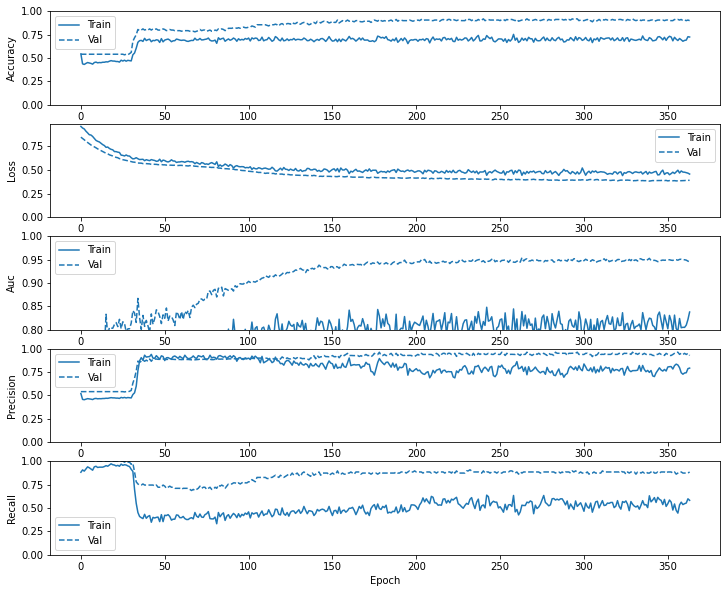

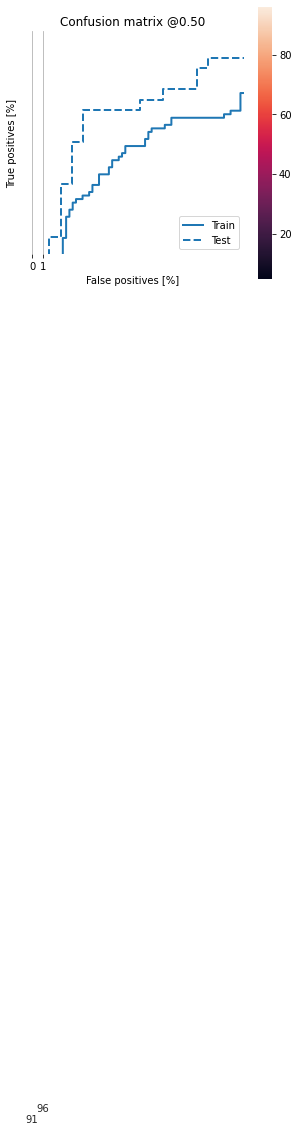

In [20]:
%%time
expId = 102
desc = str(expId) + " AngleEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_102, history_102 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 889s 68s/step - loss: 0.6922 - tp: 224.2143 - fp: 189.5714 - tn: 96.9286 - fn: 58.1429 - accuracy: 0.5973 - precision: 0.5720 - recall: 0.8110 - auc: 0.7366 - val_loss: 0.6768 - val_tp: 80.0000 - val_fp: 71.0000 - val_tn: 2.0000 - val_fn: 6.0000 - val_accuracy: 0.5157 - val_precision: 0.5298 - val_recall: 0.9302 - val_auc: 0.6311
Epoch 2/10000
13/13 [==============================] - 889s 68s/step - loss: 0.6867 - tp: 118.0714 - fp: 181.0714 - tn: 10.8571 - fn: 59.8571 - accuracy: 0.3489 - precision: 0.3918 - recall: 0.6818 - auc: 0.4332 - val_loss: 0.6714 - val_tp: 77.0000 - val_fp: 66.0000 - val_tn: 7.0000 - val_fn: 9.0000 - val_accuracy: 0.5283 - val_precision: 0.5385 - val_recall: 0.8953 - val_auc: 0.6623
Epoch 3/10000
13/13 [==============================] - 891s 68s/step - loss: 0.6720 - tp: 96.4286 - fp: 131.0714 - tn: 62.7143 - fn: 79.6429 - accuracy: 0.4226 - precision: 0.4165 - recall: 0.5933 - auc: 0.4979 - val_loss: 0.6

13/13 [==============================] - 892s 69s/step - loss: 0.6077 - tp: 64.6429 - fp: 8.9286 - tn: 178.6429 - fn: 117.6429 - accuracy: 0.6555 - precision: 0.8870 - recall: 0.3563 - auc: 0.7594 - val_loss: 0.6012 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7901
Epoch 23/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6253 - tp: 54.2857 - fp: 6.5000 - tn: 181.9286 - fn: 127.1429 - accuracy: 0.6315 - precision: 0.9028 - recall: 0.2885 - auc: 0.7622 - val_loss: 0.5995 - val_tp: 46.0000 - val_fp: 2.0000 - val_tn: 71.0000 - val_fn: 40.0000 - val_accuracy: 0.7358 - val_precision: 0.9583 - val_recall: 0.5349 - val_auc: 0.7903
Epoch 24/10000
13/13 [==============================] - 891s 69s/step - loss: 0.6044 - tp: 55.8571 - fp: 6.3571 - tn: 187.3571 - fn: 120.2857 - accuracy: 0.6585 - precision: 0.9051 - recall: 0.3245 - auc: 0.7457 - val_loss: 0.5973 - val_tp

13/13 [==============================] - 890s 68s/step - loss: 0.6049 - tp: 63.2143 - fp: 7.0000 - tn: 184.7857 - fn: 114.8571 - accuracy: 0.6714 - precision: 0.9096 - recall: 0.3505 - auc: 0.7357 - val_loss: 0.5773 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8648
Epoch 44/10000
13/13 [==============================] - 890s 68s/step - loss: 0.6042 - tp: 60.9286 - fp: 5.4286 - tn: 187.8571 - fn: 115.6429 - accuracy: 0.6746 - precision: 0.8936 - recall: 0.3435 - auc: 0.7343 - val_loss: 0.5763 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.8556
Epoch 45/10000
13/13 [==============================] - 891s 69s/step - loss: 0.5929 - tp: 71.5714 - fp: 7.4286 - tn: 183.8571 - fn: 107.0000 - accuracy: 0.6823 - precision: 0.8983 - recall: 0.3895 - auc: 0.7294 - val_loss: 0.5773 - val_tp

13/13 [==============================] - 892s 69s/step - loss: 0.5971 - tp: 70.5714 - fp: 5.5000 - tn: 186.1429 - fn: 107.6429 - accuracy: 0.6804 - precision: 0.9408 - recall: 0.3684 - auc: 0.6708 - val_loss: 0.5574 - val_tp: 48.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 38.0000 - val_accuracy: 0.7421 - val_precision: 0.9412 - val_recall: 0.5581 - val_auc: 0.8826
Epoch 65/10000
13/13 [==============================] - 892s 69s/step - loss: 0.5859 - tp: 69.5714 - fp: 8.1429 - tn: 183.4286 - fn: 108.7143 - accuracy: 0.6820 - precision: 0.8954 - recall: 0.3824 - auc: 0.6934 - val_loss: 0.5587 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.8724
Epoch 66/10000
13/13 [==============================] - 893s 69s/step - loss: 0.5496 - tp: 83.3571 - fp: 7.5714 - tn: 185.0714 - fn: 93.8571 - accuracy: 0.7421 - precision: 0.9279 - recall: 0.4960 - auc: 0.7585 - val_loss: 0.5571 - val_tp:

13/13 [==============================] - 893s 69s/step - loss: 0.5794 - tp: 75.2143 - fp: 7.7143 - tn: 185.9286 - fn: 101.0000 - accuracy: 0.7044 - precision: 0.9098 - recall: 0.4118 - auc: 0.7227 - val_loss: 0.5469 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9060
Epoch 86/10000
13/13 [==============================] - 891s 68s/step - loss: 0.5632 - tp: 86.6429 - fp: 6.7143 - tn: 179.2143 - fn: 97.2857 - accuracy: 0.7147 - precision: 0.9296 - recall: 0.4691 - auc: 0.7356 - val_loss: 0.5462 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9055
Epoch 87/10000
13/13 [==============================] - 893s 69s/step - loss: 0.5606 - tp: 77.8571 - fp: 9.0714 - tn: 180.5714 - fn: 102.3571 - accuracy: 0.7095 - precision: 0.8946 - recall: 0.4611 - auc: 0.7360 - val_loss: 0.5475 - val_tp:

13/13 [==============================] - 893s 69s/step - loss: 0.5475 - tp: 89.8571 - fp: 7.1429 - tn: 180.7143 - fn: 92.1429 - accuracy: 0.7274 - precision: 0.9317 - recall: 0.4924 - auc: 0.7487 - val_loss: 0.5398 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9037
Epoch 107/10000
13/13 [==============================] - 893s 69s/step - loss: 0.5662 - tp: 83.6429 - fp: 6.0714 - tn: 182.9286 - fn: 97.2143 - accuracy: 0.7209 - precision: 0.9364 - recall: 0.4546 - auc: 0.7417 - val_loss: 0.5371 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9039
Epoch 108/10000
13/13 [==============================] - 892s 69s/step - loss: 0.5597 - tp: 82.5714 - fp: 9.7143 - tn: 179.8571 - fn: 97.7143 - accuracy: 0.7057 - precision: 0.8681 - recall: 0.4657 - auc: 0.7240 - val_loss: 0.5366 - val_tp:

13/13 [==============================] - 889s 68s/step - loss: 0.5574 - tp: 84.3571 - fp: 9.0000 - tn: 177.7143 - fn: 98.7857 - accuracy: 0.7130 - precision: 0.9121 - recall: 0.4788 - auc: 0.7096 - val_loss: 0.5344 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.8984
Epoch 128/10000
13/13 [==============================] - 892s 69s/step - loss: 0.5601 - tp: 81.6429 - fp: 8.3571 - tn: 181.9286 - fn: 97.9286 - accuracy: 0.7070 - precision: 0.9083 - recall: 0.4506 - auc: 0.7515 - val_loss: 0.5330 - val_tp: 57.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 29.0000 - val_accuracy: 0.7925 - val_precision: 0.9344 - val_recall: 0.6628 - val_auc: 0.9095
Epoch 129/10000
13/13 [==============================] - 891s 69s/step - loss: 0.5736 - tp: 82.7143 - fp: 8.0714 - tn: 176.4286 - fn: 102.6429 - accuracy: 0.6989 - precision: 0.9314 - recall: 0.4485 - auc: 0.7395 - val_loss: 0.5294 - val_tp

13/13 [==============================] - 892s 69s/step - loss: 0.5487 - tp: 84.0714 - fp: 9.0000 - tn: 182.6429 - fn: 94.1429 - accuracy: 0.7182 - precision: 0.8934 - recall: 0.4727 - auc: 0.7373 - val_loss: 0.5243 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9142
Epoch 149/10000
13/13 [==============================] - 889s 68s/step - loss: 0.5820 - tp: 83.6429 - fp: 10.1429 - tn: 176.5000 - fn: 99.5714 - accuracy: 0.6811 - precision: 0.8751 - recall: 0.4275 - auc: 0.6990 - val_loss: 0.5231 - val_tp: 55.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 31.0000 - val_accuracy: 0.7799 - val_precision: 0.9322 - val_recall: 0.6395 - val_auc: 0.9174
Epoch 150/10000
13/13 [==============================] - 890s 68s/step - loss: 0.5438 - tp: 80.4286 - fp: 5.8571 - tn: 190.7143 - fn: 92.8571 - accuracy: 0.7343 - precision: 0.9287 - recall: 0.4628 - auc: 0.7490 - val_loss: 0.5248 - val_tp

13/13 [==============================] - 890s 68s/step - loss: 0.5501 - tp: 88.7143 - fp: 7.4286 - tn: 183.5714 - fn: 90.1429 - accuracy: 0.7300 - precision: 0.9364 - recall: 0.4838 - auc: 0.7242 - val_loss: 0.5186 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9137
Epoch 170/10000
13/13 [==============================] - 889s 68s/step - loss: 0.5441 - tp: 87.7857 - fp: 8.2857 - tn: 186.0714 - fn: 87.7143 - accuracy: 0.7390 - precision: 0.8973 - recall: 0.4984 - auc: 0.7477 - val_loss: 0.5192 - val_tp: 56.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 30.0000 - val_accuracy: 0.7862 - val_precision: 0.9333 - val_recall: 0.6512 - val_auc: 0.9173
Epoch 171/10000
13/13 [==============================] - 891s 69s/step - loss: 0.5300 - tp: 85.7857 - fp: 7.5000 - tn: 187.0000 - fn: 89.5714 - accuracy: 0.7433 - precision: 0.9209 - recall: 0.4998 - auc: 0.7663 - val_loss: 0.5161 - val_tp:

13/13 [==============================] - 848s 65s/step - loss: 0.5274 - tp: 84.6429 - fp: 8.0714 - tn: 189.0714 - fn: 88.0714 - accuracy: 0.7442 - precision: 0.9117 - recall: 0.4957 - auc: 0.7399 - val_loss: 0.5093 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9225
Epoch 191/10000
13/13 [==============================] - 848s 65s/step - loss: 0.5406 - tp: 85.2143 - fp: 7.0000 - tn: 186.0000 - fn: 91.6429 - accuracy: 0.7309 - precision: 0.9129 - recall: 0.4810 - auc: 0.7566 - val_loss: 0.5100 - val_tp: 58.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 28.0000 - val_accuracy: 0.7987 - val_precision: 0.9355 - val_recall: 0.6744 - val_auc: 0.9200
Epoch 192/10000
13/13 [==============================] - 849s 65s/step - loss: 0.5106 - tp: 97.5000 - fp: 6.0000 - tn: 188.3571 - fn: 78.0000 - accuracy: 0.7772 - precision: 0.9526 - recall: 0.5526 - auc: 0.7694 - val_loss: 0.5078 - val_tp:

13/13 [==============================] - 849s 65s/step - loss: 0.5296 - tp: 92.0000 - fp: 2.7857 - tn: 188.3571 - fn: 86.7143 - accuracy: 0.7543 - precision: 0.9737 - recall: 0.5049 - auc: 0.7179 - val_loss: 0.5062 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9173
Epoch 212/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5616 - tp: 80.2857 - fp: 11.0000 - tn: 182.4286 - fn: 96.1429 - accuracy: 0.7059 - precision: 0.8778 - recall: 0.4511 - auc: 0.7104 - val_loss: 0.5051 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9209
Epoch 213/10000
13/13 [==============================] - 848s 65s/step - loss: 0.5453 - tp: 88.6429 - fp: 10.0714 - tn: 181.2143 - fn: 89.9286 - accuracy: 0.7213 - precision: 0.8791 - recall: 0.4809 - auc: 0.7556 - val_loss: 0.5033 - val_t

13/13 [==============================] - 849s 65s/step - loss: 0.5256 - tp: 83.8571 - fp: 7.4286 - tn: 189.7857 - fn: 88.7857 - accuracy: 0.7486 - precision: 0.9246 - recall: 0.4980 - auc: 0.7595 - val_loss: 0.5058 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9245
Epoch 233/10000
13/13 [==============================] - 847s 65s/step - loss: 0.5672 - tp: 75.5000 - fp: 5.7857 - tn: 185.8571 - fn: 102.7143 - accuracy: 0.7059 - precision: 0.9356 - recall: 0.4095 - auc: 0.7170 - val_loss: 0.5073 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9309
Epoch 234/10000
13/13 [==============================] - 851s 65s/step - loss: 0.5357 - tp: 85.0000 - fp: 5.6429 - tn: 187.8571 - fn: 91.3571 - accuracy: 0.7446 - precision: 0.9421 - recall: 0.4789 - auc: 0.7541 - val_loss: 0.5078 - val_tp

13/13 [==============================] - 849s 65s/step - loss: 0.5113 - tp: 93.2143 - fp: 5.7143 - tn: 188.0714 - fn: 82.8571 - accuracy: 0.7643 - precision: 0.9340 - recall: 0.5369 - auc: 0.7455 - val_loss: 0.5088 - val_tp: 59.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 27.0000 - val_accuracy: 0.8050 - val_precision: 0.9365 - val_recall: 0.6860 - val_auc: 0.9219
Epoch 254/10000
13/13 [==============================] - 851s 65s/step - loss: 0.5007 - tp: 97.0714 - fp: 7.5714 - tn: 182.3571 - fn: 82.8571 - accuracy: 0.7589 - precision: 0.9222 - recall: 0.5414 - auc: 0.8027 - val_loss: 0.5050 - val_tp: 61.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 25.0000 - val_accuracy: 0.8176 - val_precision: 0.9385 - val_recall: 0.7093 - val_auc: 0.9309
Epoch 255/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5151 - tp: 91.7143 - fp: 4.1429 - tn: 185.4286 - fn: 88.5714 - accuracy: 0.7533 - precision: 0.9676 - recall: 0.5078 - auc: 0.7839 - val_loss: 0.5069 - val_tp:

13/13 [==============================] - 848s 65s/step - loss: 0.5103 - tp: 86.7857 - fp: 8.0000 - tn: 190.7143 - fn: 84.3571 - accuracy: 0.7674 - precision: 0.8999 - recall: 0.5338 - auc: 0.7953 - val_loss: 0.5143 - val_tp: 60.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 26.0000 - val_accuracy: 0.8113 - val_precision: 0.9375 - val_recall: 0.6977 - val_auc: 0.9266
Epoch 275/10000
13/13 [==============================] - 849s 65s/step - loss: 0.5085 - tp: 95.1429 - fp: 5.0000 - tn: 186.0714 - fn: 83.6429 - accuracy: 0.7629 - precision: 0.9562 - recall: 0.5357 - auc: 0.7670 - val_loss: 0.5152 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9277
Epoch 276/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5532 - tp: 86.7143 - fp: 3.9286 - tn: 185.2857 - fn: 93.9286 - accuracy: 0.7261 - precision: 0.9586 - recall: 0.4625 - auc: 0.7218 - val_loss: 0.5190 - val_tp:

13/13 [==============================] - 850s 65s/step - loss: 0.5057 - tp: 99.5000 - fp: 10.7857 - tn: 178.3571 - fn: 81.2143 - accuracy: 0.7538 - precision: 0.8965 - recall: 0.5575 - auc: 0.7942 - val_loss: 0.5266 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9158
Epoch 296/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5318 - tp: 97.7143 - fp: 7.5000 - tn: 183.7857 - fn: 80.8571 - accuracy: 0.7524 - precision: 0.9136 - recall: 0.5423 - auc: 0.7668 - val_loss: 0.5250 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9250
Epoch 297/10000
13/13 [==============================] - 852s 65s/step - loss: 0.4980 - tp: 96.8571 - fp: 5.9286 - tn: 186.6429 - fn: 80.4286 - accuracy: 0.7663 - precision: 0.9393 - recall: 0.5519 - auc: 0.7970 - val_loss: 0.5241 - val_tp

13/13 [==============================] - 850s 65s/step - loss: 0.5136 - tp: 100.4286 - fp: 6.8571 - tn: 183.5714 - fn: 79.0000 - accuracy: 0.7564 - precision: 0.9285 - recall: 0.5518 - auc: 0.7827 - val_loss: 0.5260 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9348
Epoch 317/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4846 - tp: 102.2143 - fp: 1.8571 - tn: 191.9286 - fn: 73.8571 - accuracy: 0.7994 - precision: 0.9878 - recall: 0.5789 - auc: 0.8115 - val_loss: 0.5307 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9216
Epoch 318/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4962 - tp: 99.0714 - fp: 4.7857 - tn: 189.9286 - fn: 76.0714 - accuracy: 0.7853 - precision: 0.9620 - recall: 0.5722 - auc: 0.8006 - val_loss: 0.5283 - val_t

13/13 [==============================] - 848s 65s/step - loss: 0.5177 - tp: 92.5000 - fp: 7.9286 - tn: 192.0000 - fn: 77.4286 - accuracy: 0.7634 - precision: 0.9064 - recall: 0.5312 - auc: 0.7669 - val_loss: 0.5247 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9306
Epoch 338/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5236 - tp: 89.2143 - fp: 7.0714 - tn: 189.3571 - fn: 84.2143 - accuracy: 0.7608 - precision: 0.9330 - recall: 0.5171 - auc: 0.7380 - val_loss: 0.5268 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9356
Epoch 339/10000
13/13 [==============================] - 849s 65s/step - loss: 0.5048 - tp: 104.9286 - fp: 7.0000 - tn: 181.6429 - fn: 76.2857 - accuracy: 0.7657 - precision: 0.9436 - recall: 0.5691 - auc: 0.7676 - val_loss: 0.5300 - val_tp

13/13 [==============================] - 850s 65s/step - loss: 0.5050 - tp: 98.7143 - fp: 6.3571 - tn: 184.7143 - fn: 80.0714 - accuracy: 0.7738 - precision: 0.9528 - recall: 0.5596 - auc: 0.7703 - val_loss: 0.5183 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9307
Epoch 359/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4899 - tp: 107.7857 - fp: 6.0714 - tn: 181.4286 - fn: 74.5714 - accuracy: 0.7835 - precision: 0.9557 - recall: 0.5902 - auc: 0.7887 - val_loss: 0.5192 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9357
Epoch 360/10000
13/13 [==============================] - 848s 65s/step - loss: 0.5336 - tp: 100.4286 - fp: 11.3571 - tn: 177.6429 - fn: 80.4286 - accuracy: 0.7486 - precision: 0.8949 - recall: 0.5517 - auc: 0.7533 - val_loss: 0.5176 - val_

13/13 [==============================] - 848s 65s/step - loss: 0.4913 - tp: 105.6429 - fp: 4.2143 - tn: 187.9286 - fn: 72.0714 - accuracy: 0.7921 - precision: 0.9628 - recall: 0.5953 - auc: 0.7919 - val_loss: 0.5186 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9390
Epoch 380/10000
13/13 [==============================] - 851s 65s/step - loss: 0.5146 - tp: 95.6429 - fp: 7.6429 - tn: 186.9286 - fn: 79.6429 - accuracy: 0.7618 - precision: 0.9128 - recall: 0.5463 - auc: 0.7497 - val_loss: 0.5179 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9409
Epoch 381/10000
13/13 [==============================] - 852s 66s/step - loss: 0.4676 - tp: 108.0714 - fp: 5.8571 - tn: 188.2857 - fn: 67.6429 - accuracy: 0.8009 - precision: 0.9477 - recall: 0.6183 - auc: 0.8119 - val_loss: 0.5188 - val_t

13/13 [==============================] - 850s 65s/step - loss: 0.5058 - tp: 101.6429 - fp: 5.5000 - tn: 184.7143 - fn: 78.0000 - accuracy: 0.7617 - precision: 0.9437 - recall: 0.5561 - auc: 0.7675 - val_loss: 0.5123 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9401
Epoch 401/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4752 - tp: 102.7857 - fp: 8.5714 - tn: 185.0000 - fn: 73.5000 - accuracy: 0.7842 - precision: 0.9283 - recall: 0.5931 - auc: 0.7903 - val_loss: 0.5108 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9352
Epoch 402/10000
13/13 [==============================] - 851s 65s/step - loss: 0.5125 - tp: 101.7857 - fp: 5.6429 - tn: 185.9286 - fn: 76.5000 - accuracy: 0.7682 - precision: 0.9500 - recall: 0.5535 - auc: 0.7451 - val_loss: 0.5135 - val_

13/13 [==============================] - 848s 65s/step - loss: 0.4781 - tp: 104.6429 - fp: 5.0714 - tn: 189.7857 - fn: 70.3571 - accuracy: 0.8028 - precision: 0.9528 - recall: 0.6068 - auc: 0.7819 - val_loss: 0.5152 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9385
Epoch 422/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4961 - tp: 107.7857 - fp: 8.5714 - tn: 183.4286 - fn: 70.0714 - accuracy: 0.7817 - precision: 0.9055 - recall: 0.6002 - auc: 0.7769 - val_loss: 0.5145 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9412
Epoch 423/10000
13/13 [==============================] - 849s 65s/step - loss: 0.5387 - tp: 100.6429 - fp: 7.2143 - tn: 176.4286 - fn: 85.5714 - accuracy: 0.7348 - precision: 0.9265 - recall: 0.5326 - auc: 0.7566 - val_loss: 0.5097 - val_

13/13 [==============================] - 851s 65s/step - loss: 0.5151 - tp: 98.5714 - fp: 7.0000 - tn: 182.0714 - fn: 82.2143 - accuracy: 0.7558 - precision: 0.9316 - recall: 0.5372 - auc: 0.7630 - val_loss: 0.5089 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9345
Epoch 443/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4882 - tp: 108.5000 - fp: 9.8571 - tn: 181.7857 - fn: 69.7143 - accuracy: 0.7804 - precision: 0.9079 - recall: 0.6130 - auc: 0.7974 - val_loss: 0.5112 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9456
Epoch 444/10000
13/13 [==============================] - 851s 65s/step - loss: 0.4770 - tp: 102.7857 - fp: 7.0714 - tn: 188.5000 - fn: 71.5000 - accuracy: 0.7982 - precision: 0.9399 - recall: 0.6075 - auc: 0.8098 - val_loss: 0.5099 - val_t

13/13 [==============================] - 850s 65s/step - loss: 0.4908 - tp: 96.4286 - fp: 4.2143 - tn: 188.0714 - fn: 81.1429 - accuracy: 0.7748 - precision: 0.9641 - recall: 0.5522 - auc: 0.7729 - val_loss: 0.5054 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9466
Epoch 464/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4881 - tp: 104.3571 - fp: 7.3571 - tn: 181.2143 - fn: 76.9286 - accuracy: 0.7770 - precision: 0.9406 - recall: 0.5823 - auc: 0.7987 - val_loss: 0.5018 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9445
Epoch 465/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4473 - tp: 114.9286 - fp: 6.0714 - tn: 187.5000 - fn: 61.3571 - accuracy: 0.8236 - precision: 0.9514 - recall: 0.6574 - auc: 0.8198 - val_loss: 0.5031 - val_t

13/13 [==============================] - 848s 65s/step - loss: 0.5049 - tp: 107.6429 - fp: 7.4286 - tn: 172.1429 - fn: 82.6429 - accuracy: 0.7535 - precision: 0.9382 - recall: 0.5679 - auc: 0.7679 - val_loss: 0.5002 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9402
Epoch 485/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4871 - tp: 109.4286 - fp: 6.0714 - tn: 184.3571 - fn: 70.0000 - accuracy: 0.7856 - precision: 0.9412 - recall: 0.5891 - auc: 0.7891 - val_loss: 0.5053 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9434
Epoch 486/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4775 - tp: 105.9286 - fp: 7.9286 - tn: 187.7143 - fn: 68.2857 - accuracy: 0.7870 - precision: 0.9204 - recall: 0.6050 - auc: 0.7825 - val_loss: 0.5035 - val_

13/13 [==============================] - 850s 65s/step - loss: 0.5033 - tp: 108.3571 - fp: 6.0000 - tn: 177.6429 - fn: 77.8571 - accuracy: 0.7571 - precision: 0.9439 - recall: 0.5689 - auc: 0.7552 - val_loss: 0.4991 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9398
Epoch 506/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4771 - tp: 110.4286 - fp: 5.3571 - tn: 184.9286 - fn: 69.1429 - accuracy: 0.7960 - precision: 0.9487 - recall: 0.6004 - auc: 0.7919 - val_loss: 0.4982 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9412
Epoch 507/10000
13/13 [==============================] - 848s 65s/step - loss: 0.4837 - tp: 106.6429 - fp: 7.0000 - tn: 186.5000 - fn: 69.7143 - accuracy: 0.7935 - precision: 0.9352 - recall: 0.6001 - auc: 0.7802 - val_loss: 0.4969 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.4953 - tp: 100.5714 - fp: 8.1429 - tn: 184.0714 - fn: 77.0714 - accuracy: 0.7654 - precision: 0.9205 - recall: 0.5652 - auc: 0.7491 - val_loss: 0.4997 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9366
Epoch 527/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4873 - tp: 106.6429 - fp: 6.5714 - tn: 185.2857 - fn: 71.3571 - accuracy: 0.7871 - precision: 0.9445 - recall: 0.5896 - auc: 0.7828 - val_loss: 0.4955 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9424
Epoch 528/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4637 - tp: 111.2857 - fp: 5.2143 - tn: 186.3571 - fn: 67.0000 - accuracy: 0.8067 - precision: 0.9547 - recall: 0.6339 - auc: 0.8289 - val_loss: 0.5017 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.4696 - tp: 115.0000 - fp: 9.0000 - tn: 181.5000 - fn: 64.3571 - accuracy: 0.7996 - precision: 0.9273 - recall: 0.6427 - auc: 0.8027 - val_loss: 0.4941 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9468
Epoch 548/10000
13/13 [==============================] - 848s 65s/step - loss: 0.4523 - tp: 108.3571 - fp: 6.7143 - tn: 187.5714 - fn: 67.2143 - accuracy: 0.8122 - precision: 0.9449 - recall: 0.6390 - auc: 0.8194 - val_loss: 0.4966 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9392
Epoch 549/10000
13/13 [==============================] - 851s 66s/step - loss: 0.4969 - tp: 106.8571 - fp: 7.1429 - tn: 180.6429 - fn: 75.2143 - accuracy: 0.7690 - precision: 0.9350 - recall: 0.5658 - auc: 0.7671 - val_loss: 0.4943 - val_

13/13 [==============================] - 850s 65s/step - loss: 0.4846 - tp: 105.2143 - fp: 4.5714 - tn: 185.1429 - fn: 74.9286 - accuracy: 0.7797 - precision: 0.9663 - recall: 0.5677 - auc: 0.7688 - val_loss: 0.4880 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9461
Epoch 569/10000
13/13 [==============================] - 850s 65s/step - loss: 0.5074 - tp: 100.5714 - fp: 6.9286 - tn: 184.1429 - fn: 78.2143 - accuracy: 0.7700 - precision: 0.9399 - recall: 0.5473 - auc: 0.7570 - val_loss: 0.4912 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9433
Epoch 570/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4729 - tp: 109.4286 - fp: 6.6429 - tn: 181.8571 - fn: 71.9286 - accuracy: 0.7888 - precision: 0.9487 - recall: 0.6043 - auc: 0.7774 - val_loss: 0.4902 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.4629 - tp: 110.9286 - fp: 3.8571 - tn: 190.9286 - fn: 64.1429 - accuracy: 0.8183 - precision: 0.9747 - recall: 0.6196 - auc: 0.7966 - val_loss: 0.4821 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9474
Epoch 590/10000
13/13 [==============================] - 848s 65s/step - loss: 0.4911 - tp: 109.5714 - fp: 8.2857 - tn: 178.1429 - fn: 73.8571 - accuracy: 0.7870 - precision: 0.9371 - recall: 0.6131 - auc: 0.7621 - val_loss: 0.4831 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9474
Epoch 591/10000
13/13 [==============================] - 847s 65s/step - loss: 0.4462 - tp: 109.2857 - fp: 2.8571 - tn: 191.7143 - fn: 66.0000 - accuracy: 0.8195 - precision: 0.9820 - recall: 0.6304 - auc: 0.7904 - val_loss: 0.4858 - val_

13/13 [==============================] - 850s 65s/step - loss: 0.5114 - tp: 95.5714 - fp: 6.7143 - tn: 190.0000 - fn: 77.5714 - accuracy: 0.7592 - precision: 0.9278 - recall: 0.5260 - auc: 0.7630 - val_loss: 0.4873 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9403
Epoch 611/10000
13/13 [==============================] - 849s 65s/step - loss: 0.5065 - tp: 99.9286 - fp: 6.0000 - tn: 186.4286 - fn: 77.5000 - accuracy: 0.7612 - precision: 0.9393 - recall: 0.5403 - auc: 0.7361 - val_loss: 0.4811 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9470
Epoch 612/10000
13/13 [==============================] - 852s 66s/step - loss: 0.4522 - tp: 104.0714 - fp: 4.9286 - tn: 191.3571 - fn: 69.5000 - accuracy: 0.8152 - precision: 0.9587 - recall: 0.6238 - auc: 0.8037 - val_loss: 0.4851 - val_tp

13/13 [==============================] - 848s 65s/step - loss: 0.5032 - tp: 100.1429 - fp: 5.5000 - tn: 186.7857 - fn: 77.4286 - accuracy: 0.7706 - precision: 0.9438 - recall: 0.5483 - auc: 0.7685 - val_loss: 0.4836 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9415
Epoch 632/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4733 - tp: 104.9286 - fp: 4.4286 - tn: 189.2857 - fn: 71.2143 - accuracy: 0.8014 - precision: 0.9622 - recall: 0.6016 - auc: 0.7803 - val_loss: 0.4773 - val_tp: 57.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 29.0000 - val_accuracy: 0.7987 - val_precision: 0.9500 - val_recall: 0.6628 - val_auc: 0.9496
Epoch 633/10000
13/13 [==============================] - 853s 66s/step - loss: 0.4391 - tp: 118.3571 - fp: 4.3571 - tn: 185.7857 - fn: 61.3571 - accuracy: 0.8253 - precision: 0.9705 - recall: 0.6687 - auc: 0.8184 - val_loss: 0.4792 - val_

13/13 [==============================] - 850s 65s/step - loss: 0.4948 - tp: 101.5000 - fp: 5.0714 - tn: 185.7143 - fn: 77.5714 - accuracy: 0.7706 - precision: 0.9453 - recall: 0.5616 - auc: 0.7841 - val_loss: 0.4817 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9456
Epoch 653/10000
13/13 [==============================] - 851s 65s/step - loss: 0.4396 - tp: 119.7857 - fp: 7.7857 - tn: 184.5000 - fn: 57.7857 - accuracy: 0.8229 - precision: 0.9388 - recall: 0.6735 - auc: 0.8198 - val_loss: 0.4790 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9442
Epoch 654/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4771 - tp: 109.0000 - fp: 4.8571 - tn: 184.5714 - fn: 71.4286 - accuracy: 0.7982 - precision: 0.9628 - recall: 0.6173 - auc: 0.7764 - val_loss: 0.4794 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.5052 - tp: 106.1429 - fp: 5.5000 - tn: 178.7857 - fn: 79.4286 - accuracy: 0.7634 - precision: 0.9555 - recall: 0.5696 - auc: 0.7654 - val_loss: 0.4765 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9545
Epoch 674/10000
13/13 [==============================] - 847s 65s/step - loss: 0.4393 - tp: 113.5000 - fp: 6.5000 - tn: 187.5714 - fn: 62.2857 - accuracy: 0.8179 - precision: 0.9535 - recall: 0.6416 - auc: 0.8179 - val_loss: 0.4793 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9486
Epoch 675/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4386 - tp: 112.0714 - fp: 5.9286 - tn: 193.0714 - fn: 58.7857 - accuracy: 0.8345 - precision: 0.9488 - recall: 0.6697 - auc: 0.8176 - val_loss: 0.4841 - val_

13/13 [==============================] - 851s 65s/step - loss: 0.4486 - tp: 112.0714 - fp: 4.9286 - tn: 184.2143 - fn: 68.6429 - accuracy: 0.8066 - precision: 0.9596 - recall: 0.6294 - auc: 0.8066 - val_loss: 0.4722 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9517
Epoch 695/10000
13/13 [==============================] - 849s 65s/step - loss: 0.4839 - tp: 102.7143 - fp: 5.2857 - tn: 187.0000 - fn: 74.8571 - accuracy: 0.7793 - precision: 0.9614 - recall: 0.5658 - auc: 0.7604 - val_loss: 0.4734 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9509
Epoch 696/10000
13/13 [==============================] - 848s 65s/step - loss: 0.4639 - tp: 114.6429 - fp: 5.7857 - tn: 181.1429 - fn: 68.2857 - accuracy: 0.7918 - precision: 0.9603 - recall: 0.6166 - auc: 0.7960 - val_loss: 0.4760 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.4300 - tp: 117.2857 - fp: 7.0714 - tn: 184.0000 - fn: 61.5000 - accuracy: 0.8216 - precision: 0.9517 - recall: 0.6670 - auc: 0.8430 - val_loss: 0.4755 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9457
Epoch 716/10000
13/13 [==============================] - 852s 66s/step - loss: 0.4499 - tp: 112.4286 - fp: 8.0714 - tn: 181.9286 - fn: 67.4286 - accuracy: 0.7989 - precision: 0.9316 - recall: 0.6346 - auc: 0.8077 - val_loss: 0.4741 - val_tp: 53.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 33.0000 - val_accuracy: 0.7736 - val_precision: 0.9464 - val_recall: 0.6163 - val_auc: 0.9444
Epoch 717/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4822 - tp: 104.7857 - fp: 8.9286 - tn: 186.3571 - fn: 69.7857 - accuracy: 0.7831 - precision: 0.9271 - recall: 0.5908 - auc: 0.7709 - val_loss: 0.4745 - val_

13/13 [==============================] - 852s 66s/step - loss: 0.4773 - tp: 100.7143 - fp: 5.5714 - tn: 188.2143 - fn: 75.3571 - accuracy: 0.7813 - precision: 0.9494 - recall: 0.5730 - auc: 0.7690 - val_loss: 0.4766 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9446
Epoch 737/10000
13/13 [==============================] - 850s 65s/step - loss: 0.4861 - tp: 100.0714 - fp: 5.3571 - tn: 186.4286 - fn: 78.0000 - accuracy: 0.7766 - precision: 0.9492 - recall: 0.5552 - auc: 0.7564 - val_loss: 0.4749 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9446
Epoch 738/10000
13/13 [==============================] - 852s 66s/step - loss: 0.4863 - tp: 116.6429 - fp: 7.8571 - tn: 173.6429 - fn: 71.7143 - accuracy: 0.7853 - precision: 0.9328 - recall: 0.6336 - auc: 0.7859 - val_loss: 0.4755 - val_

13/13 [==============================] - 849s 65s/step - loss: 0.4626 - tp: 111.8571 - fp: 5.2143 - tn: 181.4286 - fn: 71.3571 - accuracy: 0.7919 - precision: 0.9641 - recall: 0.6096 - auc: 0.8135 - val_loss: 0.4701 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9487
Epoch 758/10000
13/13 [==============================] - 851s 65s/step - loss: 0.4762 - tp: 108.1429 - fp: 5.8571 - tn: 186.9286 - fn: 68.9286 - accuracy: 0.7934 - precision: 0.9474 - recall: 0.5943 - auc: 0.7808 - val_loss: 0.4734 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9435
Epoch 759/10000
13/13 [==============================] - 851s 65s/step - loss: 0.4673 - tp: 106.2143 - fp: 3.6429 - tn: 185.2143 - fn: 74.7857 - accuracy: 0.7958 - precision: 0.9683 - recall: 0.6080 - auc: 0.7919 - val_loss: 0.4684 - val_

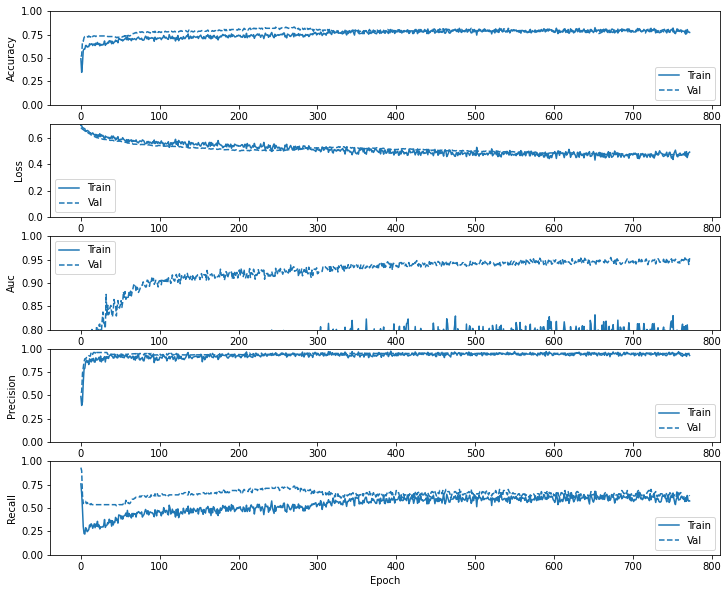

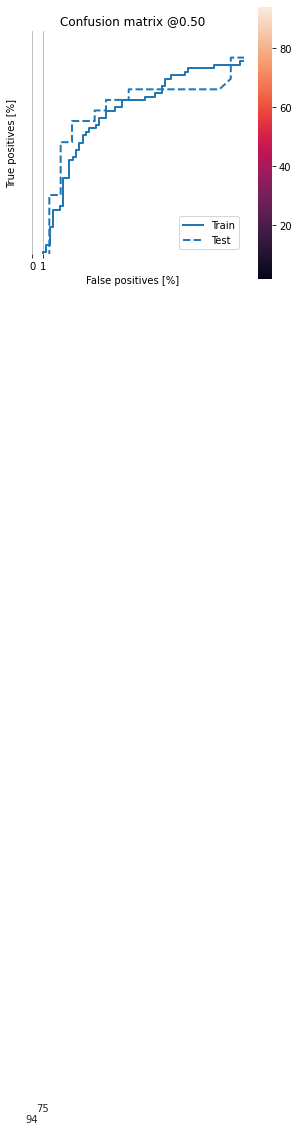

In [21]:
%%time
expId = 103
desc = str(expId) + " AngleEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_103, history_103 = runTheExperiments(expId, desc)

## IQPEmbedding

Epoch 1/10000
13/13 [==============================] - 528s 41s/step - loss: 0.7016 - tp: 136.0714 - fp: 62.3571 - tn: 224.1429 - fn: 146.2857 - accuracy: 0.6512 - precision: 0.7068 - recall: 0.5050 - auc: 0.7312 - val_loss: 0.7113 - val_tp: 31.0000 - val_fp: 27.0000 - val_tn: 46.0000 - val_fn: 55.0000 - val_accuracy: 0.4843 - val_precision: 0.5345 - val_recall: 0.3605 - val_auc: 0.4321
Epoch 2/10000
13/13 [==============================] - 529s 41s/step - loss: 0.7083 - tp: 68.4286 - fp: 68.7143 - tn: 123.2143 - fn: 109.5000 - accuracy: 0.5230 - precision: 0.4957 - recall: 0.4196 - auc: 0.4974 - val_loss: 0.7161 - val_tp: 27.0000 - val_fp: 27.0000 - val_tn: 46.0000 - val_fn: 59.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.3140 - val_auc: 0.4035
Epoch 3/10000
13/13 [==============================] - 528s 41s/step - loss: 0.7151 - tp: 58.5000 - fp: 52.7857 - tn: 141.0000 - fn: 117.5714 - accuracy: 0.5530 - precision: 0.5300 - recall: 0.3426 - auc: 0.4737 - val_los

13/13 [==============================] - 529s 41s/step - loss: 0.6877 - tp: 47.0714 - fp: 15.2143 - tn: 172.3571 - fn: 135.2143 - accuracy: 0.5947 - precision: 0.7873 - recall: 0.2607 - auc: 0.5337 - val_loss: 0.7627 - val_tp: 8.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 78.0000 - val_accuracy: 0.4717 - val_precision: 0.5714 - val_recall: 0.0930 - val_auc: 0.2879
Epoch 23/10000
13/13 [==============================] - 528s 41s/step - loss: 0.6830 - tp: 47.7857 - fp: 9.0714 - tn: 179.3571 - fn: 133.6429 - accuracy: 0.6076 - precision: 0.8483 - recall: 0.2545 - auc: 0.5663 - val_loss: 0.7630 - val_tp: 5.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 81.0000 - val_accuracy: 0.4591 - val_precision: 0.5000 - val_recall: 0.0581 - val_auc: 0.2768
Epoch 24/10000
13/13 [==============================] - 529s 41s/step - loss: 0.6779 - tp: 47.7857 - fp: 13.8571 - tn: 179.8571 - fn: 128.3571 - accuracy: 0.6237 - precision: 0.7982 - recall: 0.2882 - auc: 0.5960 - val_loss: 0.7647 - val_tp

13/13 [==============================] - 528s 41s/step - loss: 0.6782 - tp: 52.7143 - fp: 12.2857 - tn: 179.5000 - fn: 125.3571 - accuracy: 0.6287 - precision: 0.8153 - recall: 0.2910 - auc: 0.5736 - val_loss: 0.7877 - val_tp: 17.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 69.0000 - val_accuracy: 0.5094 - val_precision: 0.6538 - val_recall: 0.1977 - val_auc: 0.3073
Epoch 44/10000
13/13 [==============================] - 529s 41s/step - loss: 0.6846 - tp: 41.0000 - fp: 7.5714 - tn: 185.7143 - fn: 135.5714 - accuracy: 0.6167 - precision: 0.8193 - recall: 0.2270 - auc: 0.5480 - val_loss: 0.7874 - val_tp: 18.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 68.0000 - val_accuracy: 0.5157 - val_precision: 0.6667 - val_recall: 0.2093 - val_auc: 0.3433
Epoch 45/10000
13/13 [==============================] - 531s 41s/step - loss: 0.6731 - tp: 51.6429 - fp: 10.4286 - tn: 180.8571 - fn: 126.9286 - accuracy: 0.6226 - precision: 0.8225 - recall: 0.2839 - auc: 0.5938 - val_loss: 0.7882 - val_

13/13 [==============================] - 530s 41s/step - loss: 0.6787 - tp: 44.9286 - fp: 7.3571 - tn: 184.2857 - fn: 133.2857 - accuracy: 0.6134 - precision: 0.8707 - recall: 0.2412 - auc: 0.5654 - val_loss: 0.7875 - val_tp: 19.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 67.0000 - val_accuracy: 0.5283 - val_precision: 0.7037 - val_recall: 0.2209 - val_auc: 0.3475
Epoch 65/10000
13/13 [==============================] - 531s 41s/step - loss: 0.6730 - tp: 46.5714 - fp: 7.0000 - tn: 184.5714 - fn: 131.7143 - accuracy: 0.6167 - precision: 0.8447 - recall: 0.2456 - auc: 0.5794 - val_loss: 0.7864 - val_tp: 19.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 67.0000 - val_accuracy: 0.5220 - val_precision: 0.6786 - val_recall: 0.2209 - val_auc: 0.3118
Epoch 66/10000
13/13 [==============================] - 528s 41s/step - loss: 0.6752 - tp: 49.0714 - fp: 7.0714 - tn: 185.5714 - fn: 128.1429 - accuracy: 0.6420 - precision: 0.8830 - recall: 0.2849 - auc: 0.5645 - val_loss: 0.7886 - val_tp

13/13 [==============================] - 530s 41s/step - loss: 0.6683 - tp: 50.2143 - fp: 11.0714 - tn: 182.5714 - fn: 126.0000 - accuracy: 0.6280 - precision: 0.8109 - recall: 0.2708 - auc: 0.5458 - val_loss: 0.8128 - val_tp: 18.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 68.0000 - val_accuracy: 0.5220 - val_precision: 0.6923 - val_recall: 0.2093 - val_auc: 0.3389
Epoch 86/10000
13/13 [==============================] - 529s 41s/step - loss: 0.6643 - tp: 50.0000 - fp: 8.5000 - tn: 177.4286 - fn: 133.9286 - accuracy: 0.6147 - precision: 0.8609 - recall: 0.2806 - auc: 0.5914 - val_loss: 0.8114 - val_tp: 18.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 68.0000 - val_accuracy: 0.5220 - val_precision: 0.6923 - val_recall: 0.2093 - val_auc: 0.3333
Epoch 87/10000
13/13 [==============================] - 529s 41s/step - loss: 0.6609 - tp: 49.4286 - fp: 7.9286 - tn: 181.7143 - fn: 130.7857 - accuracy: 0.6276 - precision: 0.8504 - recall: 0.2903 - auc: 0.6161 - val_loss: 0.8106 - val_t

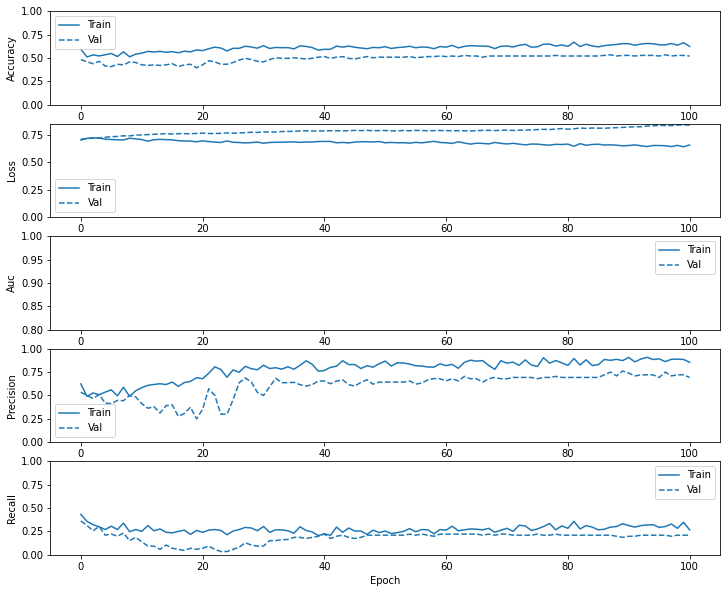

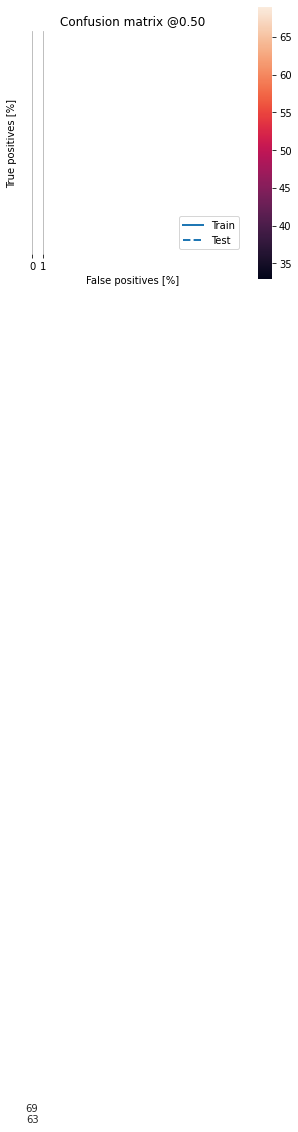

In [22]:
%%time
expId = 104
desc = str(expId) + " IQPEmbedding BasicEntanglerLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_104, history_104 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 506s 39s/step - loss: 0.7361 - tp: 92.4286 - fp: 100.9286 - tn: 185.5714 - fn: 189.9286 - accuracy: 0.4891 - precision: 0.4804 - recall: 0.3350 - auc: 0.4448 - val_loss: 0.7782 - val_tp: 4.0000 - val_fp: 23.0000 - val_tn: 50.0000 - val_fn: 82.0000 - val_accuracy: 0.3396 - val_precision: 0.1481 - val_recall: 0.0465 - val_auc: 0.2001
Epoch 2/10000
13/13 [==============================] - 507s 39s/step - loss: 0.7347 - tp: 61.8571 - fp: 62.6429 - tn: 129.2857 - fn: 116.0714 - accuracy: 0.5250 - precision: 0.4971 - recall: 0.3599 - auc: 0.4633 - val_loss: 0.7706 - val_tp: 4.0000 - val_fp: 18.0000 - val_tn: 55.0000 - val_fn: 82.0000 - val_accuracy: 0.3711 - val_precision: 0.1818 - val_recall: 0.0465 - val_auc: 0.2239
Epoch 3/10000
13/13 [==============================] - 504s 39s/step - loss: 0.7199 - tp: 53.6429 - fp: 56.0714 - tn: 137.7143 - fn: 122.4286 - accuracy: 0.5180 - precision: 0.4698 - recall: 0.2989 - auc: 0.4386 - val_loss:

13/13 [==============================] - 505s 39s/step - loss: 0.6929 - tp: 66.2857 - fp: 54.9286 - tn: 132.6429 - fn: 116.0000 - accuracy: 0.5236 - precision: 0.5359 - recall: 0.3509 - auc: 0.5142 - val_loss: 0.7024 - val_tp: 16.0000 - val_fp: 20.0000 - val_tn: 53.0000 - val_fn: 70.0000 - val_accuracy: 0.4340 - val_precision: 0.4444 - val_recall: 0.1860 - val_auc: 0.4450
Epoch 23/10000
13/13 [==============================] - 506s 39s/step - loss: 0.7050 - tp: 56.0000 - fp: 60.7857 - tn: 127.6429 - fn: 125.4286 - accuracy: 0.4766 - precision: 0.4467 - recall: 0.2748 - auc: 0.4490 - val_loss: 0.7042 - val_tp: 18.0000 - val_fp: 26.0000 - val_tn: 47.0000 - val_fn: 68.0000 - val_accuracy: 0.4088 - val_precision: 0.4091 - val_recall: 0.2093 - val_auc: 0.4036
Epoch 24/10000
13/13 [==============================] - 508s 39s/step - loss: 0.7003 - tp: 64.0000 - fp: 65.5000 - tn: 128.2143 - fn: 112.1429 - accuracy: 0.5157 - precision: 0.4967 - recall: 0.3551 - auc: 0.4813 - val_loss: 0.7003 - v

13/13 [==============================] - 507s 39s/step - loss: 0.6840 - tp: 49.3571 - fp: 47.8571 - tn: 143.9286 - fn: 128.7143 - accuracy: 0.5235 - precision: 0.5041 - recall: 0.2707 - auc: 0.5374 - val_loss: 0.6860 - val_tp: 24.0000 - val_fp: 16.0000 - val_tn: 57.0000 - val_fn: 62.0000 - val_accuracy: 0.5094 - val_precision: 0.6000 - val_recall: 0.2791 - val_auc: 0.5835
Epoch 44/10000
13/13 [==============================] - 507s 39s/step - loss: 0.6845 - tp: 50.7857 - fp: 56.4286 - tn: 136.8571 - fn: 125.7857 - accuracy: 0.5196 - precision: 0.4766 - recall: 0.3184 - auc: 0.5493 - val_loss: 0.6846 - val_tp: 17.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 69.0000 - val_accuracy: 0.4969 - val_precision: 0.6071 - val_recall: 0.1977 - val_auc: 0.5797
Epoch 45/10000
13/13 [==============================] - 507s 39s/step - loss: 0.6826 - tp: 54.9286 - fp: 50.6429 - tn: 140.6429 - fn: 123.6429 - accuracy: 0.5331 - precision: 0.5370 - recall: 0.3036 - auc: 0.5484 - val_loss: 0.6825 - v

13/13 [==============================] - 507s 39s/step - loss: 0.6666 - tp: 68.7143 - fp: 58.2143 - tn: 133.4286 - fn: 109.5000 - accuracy: 0.5367 - precision: 0.5333 - recall: 0.3837 - auc: 0.5950 - val_loss: 0.6609 - val_tp: 27.0000 - val_fp: 13.0000 - val_tn: 60.0000 - val_fn: 59.0000 - val_accuracy: 0.5472 - val_precision: 0.6750 - val_recall: 0.3140 - val_auc: 0.7121
Epoch 65/10000
13/13 [==============================] - 508s 39s/step - loss: 0.6643 - tp: 64.0000 - fp: 61.6429 - tn: 129.9286 - fn: 114.2857 - accuracy: 0.5225 - precision: 0.5051 - recall: 0.3644 - auc: 0.6077 - val_loss: 0.6531 - val_tp: 38.0000 - val_fp: 9.0000 - val_tn: 64.0000 - val_fn: 48.0000 - val_accuracy: 0.6415 - val_precision: 0.8085 - val_recall: 0.4419 - val_auc: 0.7938
Epoch 66/10000
13/13 [==============================] - 509s 39s/step - loss: 0.6625 - tp: 67.5714 - fp: 55.6429 - tn: 137.0000 - fn: 109.6429 - accuracy: 0.5633 - precision: 0.5587 - recall: 0.3857 - auc: 0.6201 - val_loss: 0.6509 - va

13/13 [==============================] - 507s 39s/step - loss: 0.6241 - tp: 149.1429 - fp: 97.0714 - tn: 96.5714 - fn: 27.0714 - accuracy: 0.6606 - precision: 0.5974 - recall: 0.8603 - auc: 0.6908 - val_loss: 0.5921 - val_tp: 56.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 30.0000 - val_accuracy: 0.7925 - val_precision: 0.9492 - val_recall: 0.6512 - val_auc: 0.9286
Epoch 86/10000
13/13 [==============================] - 507s 39s/step - loss: 0.6046 - tp: 156.7857 - fp: 85.7143 - tn: 100.2143 - fn: 27.1429 - accuracy: 0.7008 - precision: 0.6578 - recall: 0.8492 - auc: 0.7388 - val_loss: 0.5887 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9218
Epoch 87/10000
13/13 [==============================] - 507s 39s/step - loss: 0.6110 - tp: 153.2143 - fp: 88.7857 - tn: 100.8571 - fn: 27.0000 - accuracy: 0.6916 - precision: 0.6384 - recall: 0.8512 - auc: 0.7001 - val_loss: 0.5872 - val_

13/13 [==============================] - 508s 39s/step - loss: 0.5951 - tp: 166.3571 - fp: 95.5000 - tn: 92.3571 - fn: 15.6429 - accuracy: 0.7052 - precision: 0.6463 - recall: 0.9115 - auc: 0.7385 - val_loss: 0.5606 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9386
Epoch 107/10000
13/13 [==============================] - 507s 39s/step - loss: 0.5987 - tp: 160.9286 - fp: 93.0000 - tn: 96.0000 - fn: 19.9286 - accuracy: 0.6905 - precision: 0.6298 - recall: 0.8774 - auc: 0.7090 - val_loss: 0.5564 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9368
Epoch 108/10000
13/13 [==============================] - 505s 39s/step - loss: 0.6108 - tp: 162.7857 - fp: 100.3571 - tn: 89.2143 - fn: 17.5000 - accuracy: 0.6739 - precision: 0.6093 - recall: 0.9077 - auc: 0.6772 - val_loss: 0.5598 - val

13/13 [==============================] - 508s 39s/step - loss: 0.5914 - tp: 170.2857 - fp: 95.5714 - tn: 91.1429 - fn: 12.8571 - accuracy: 0.7108 - precision: 0.6493 - recall: 0.9349 - auc: 0.6839 - val_loss: 0.5381 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9468
Epoch 128/10000
13/13 [==============================] - 508s 39s/step - loss: 0.5887 - tp: 163.0000 - fp: 97.8571 - tn: 92.4286 - fn: 16.5714 - accuracy: 0.6940 - precision: 0.6307 - recall: 0.9120 - auc: 0.7007 - val_loss: 0.5374 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9367
Epoch 129/10000
13/13 [==============================] - 507s 39s/step - loss: 0.5814 - tp: 173.1429 - fp: 92.3571 - tn: 92.1429 - fn: 12.2143 - accuracy: 0.7201 - precision: 0.6611 - recall: 0.9361 - auc: 0.6996 - val_loss: 0.5401 - val_

13/13 [==============================] - 507s 39s/step - loss: 0.5931 - tp: 164.6429 - fp: 106.7143 - tn: 84.9286 - fn: 13.5714 - accuracy: 0.6696 - precision: 0.6022 - recall: 0.9304 - auc: 0.6735 - val_loss: 0.5220 - val_tp: 72.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 14.0000 - val_accuracy: 0.8931 - val_precision: 0.9600 - val_recall: 0.8372 - val_auc: 0.9525
Epoch 149/10000
13/13 [==============================] - 505s 39s/step - loss: 0.5809 - tp: 171.2857 - fp: 94.9286 - tn: 91.7143 - fn: 11.9286 - accuracy: 0.7047 - precision: 0.6422 - recall: 0.9339 - auc: 0.7037 - val_loss: 0.5181 - val_tp: 73.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 13.0000 - val_accuracy: 0.8931 - val_precision: 0.9481 - val_recall: 0.8488 - val_auc: 0.9479
Epoch 150/10000
13/13 [==============================] - 504s 39s/step - loss: 0.6001 - tp: 157.8571 - fp: 103.8571 - tn: 92.7143 - fn: 15.4286 - accuracy: 0.6674 - precision: 0.5938 - recall: 0.8934 - auc: 0.6850 - val_loss: 0.5181 - va

13/13 [==============================] - 507s 39s/step - loss: 0.5678 - tp: 165.5714 - fp: 95.0714 - tn: 95.9286 - fn: 13.2857 - accuracy: 0.7119 - precision: 0.6421 - recall: 0.9308 - auc: 0.7286 - val_loss: 0.5067 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9428
Epoch 170/10000
13/13 [==============================] - 507s 39s/step - loss: 0.5817 - tp: 161.7143 - fp: 100.6429 - tn: 93.7143 - fn: 13.7857 - accuracy: 0.6894 - precision: 0.6119 - recall: 0.9149 - auc: 0.7232 - val_loss: 0.5052 - val_tp: 75.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 11.0000 - val_accuracy: 0.8931 - val_precision: 0.9259 - val_recall: 0.8721 - val_auc: 0.9352
Epoch 171/10000
13/13 [==============================] - 506s 39s/step - loss: 0.5672 - tp: 165.4286 - fp: 101.0714 - tn: 93.4286 - fn: 9.9286 - accuracy: 0.7012 - precision: 0.6197 - recall: 0.9526 - auc: 0.7064 - val_loss: 0.5078 - val

13/13 [==============================] - 507s 39s/step - loss: 0.5697 - tp: 160.1429 - fp: 102.7143 - tn: 94.4286 - fn: 12.5714 - accuracy: 0.6904 - precision: 0.6092 - recall: 0.9274 - auc: 0.7264 - val_loss: 0.4973 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9456
Epoch 191/10000
13/13 [==============================] - 509s 39s/step - loss: 0.5748 - tp: 162.2857 - fp: 101.9286 - tn: 91.0714 - fn: 14.5714 - accuracy: 0.6862 - precision: 0.6143 - recall: 0.9160 - auc: 0.7021 - val_loss: 0.5014 - val_tp: 74.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 12.0000 - val_accuracy: 0.8931 - val_precision: 0.9367 - val_recall: 0.8605 - val_auc: 0.9436
Epoch 192/10000
13/13 [==============================] - 510s 39s/step - loss: 0.5648 - tp: 163.0714 - fp: 96.8571 - tn: 97.5000 - fn: 12.4286 - accuracy: 0.6993 - precision: 0.6195 - recall: 0.9305 - auc: 0.7252 - val_loss: 0.4964 - va

13/13 [==============================] - 508s 39s/step - loss: 0.5846 - tp: 162.2857 - fp: 104.0714 - tn: 87.0714 - fn: 16.4286 - accuracy: 0.6672 - precision: 0.6031 - recall: 0.9101 - auc: 0.6882 - val_loss: 0.4940 - val_tp: 75.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 11.0000 - val_accuracy: 0.8994 - val_precision: 0.9375 - val_recall: 0.8721 - val_auc: 0.9373
Epoch 212/10000
13/13 [==============================] - 508s 39s/step - loss: 0.5746 - tp: 164.9286 - fp: 102.9286 - tn: 90.5000 - fn: 11.5000 - accuracy: 0.6817 - precision: 0.6104 - recall: 0.9315 - auc: 0.7179 - val_loss: 0.4908 - val_tp: 76.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 10.0000 - val_accuracy: 0.9057 - val_precision: 0.9383 - val_recall: 0.8837 - val_auc: 0.9424
Epoch 213/10000
13/13 [==============================] - 506s 39s/step - loss: 0.5674 - tp: 170.4286 - fp: 104.5714 - tn: 86.7143 - fn: 8.1429 - accuracy: 0.6941 - precision: 0.6159 - recall: 0.9583 - auc: 0.7194 - val_loss: 0.4911 - va

13/13 [==============================] - 504s 39s/step - loss: 0.5638 - tp: 157.6429 - fp: 98.1429 - tn: 99.0714 - fn: 15.0000 - accuracy: 0.6958 - precision: 0.6173 - recall: 0.9133 - auc: 0.7041 - val_loss: 0.4816 - val_tp: 76.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 10.0000 - val_accuracy: 0.9119 - val_precision: 0.9500 - val_recall: 0.8837 - val_auc: 0.9388
Epoch 233/10000
13/13 [==============================] - 506s 39s/step - loss: 0.5791 - tp: 165.0000 - fp: 101.9286 - tn: 89.7143 - fn: 13.2143 - accuracy: 0.6846 - precision: 0.6104 - recall: 0.9308 - auc: 0.6849 - val_loss: 0.4835 - val_tp: 77.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 9.0000 - val_accuracy: 0.9119 - val_precision: 0.9390 - val_recall: 0.8953 - val_auc: 0.9407
Epoch 234/10000
13/13 [==============================] - 505s 39s/step - loss: 0.5834 - tp: 164.1429 - fp: 106.5000 - tn: 87.0000 - fn: 12.2143 - accuracy: 0.6665 - precision: 0.5888 - recall: 0.9312 - auc: 0.6971 - val_loss: 0.4801 - val

13/13 [==============================] - 507s 39s/step - loss: 0.5781 - tp: 162.5714 - fp: 106.2857 - tn: 87.5000 - fn: 13.5000 - accuracy: 0.6696 - precision: 0.5950 - recall: 0.9283 - auc: 0.6958 - val_loss: 0.4746 - val_tp: 78.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 8.0000 - val_accuracy: 0.9119 - val_precision: 0.9286 - val_recall: 0.9070 - val_auc: 0.9516
Epoch 254/10000
13/13 [==============================] - 507s 39s/step - loss: 0.5380 - tp: 167.7143 - fp: 90.8571 - tn: 99.0714 - fn: 12.2143 - accuracy: 0.7215 - precision: 0.6424 - recall: 0.9437 - auc: 0.7662 - val_loss: 0.4754 - val_tp: 76.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 10.0000 - val_accuracy: 0.8931 - val_precision: 0.9157 - val_recall: 0.8837 - val_auc: 0.9451
Epoch 255/10000
13/13 [==============================] - 505s 39s/step - loss: 0.5793 - tp: 163.8571 - fp: 100.4286 - tn: 89.1429 - fn: 16.4286 - accuracy: 0.6855 - precision: 0.6197 - recall: 0.9087 - auc: 0.6925 - val_loss: 0.4783 - val

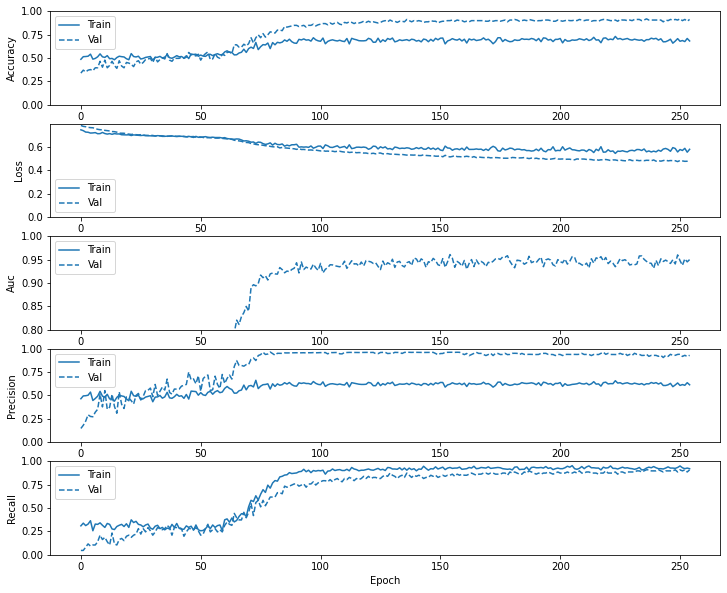

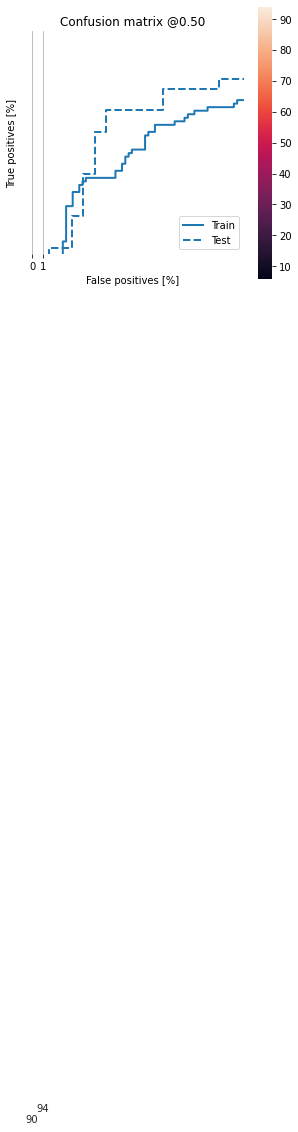

In [23]:
%%time
expId = 105
desc = str(expId) + " IQPEmbedding RandomLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.RandomLayers(weights, wires=range(n_qubits))   
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

model_105, history_105 = runTheExperiments(expId, desc)

Epoch 1/10000
13/13 [==============================] - 1032s 79s/step - loss: 0.7331 - tp: 256.2143 - fp: 191.2143 - tn: 95.2857 - fn: 26.1429 - accuracy: 0.6449 - precision: 0.6003 - recall: 0.9101 - auc: 0.6027 - val_loss: 0.7315 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.2798
Epoch 2/10000
13/13 [==============================] - 1032s 79s/step - loss: 0.7400 - tp: 154.2143 - fp: 191.4286 - tn: 0.5000 - fn: 23.7143 - accuracy: 0.4136 - precision: 0.4397 - recall: 0.8730 - auc: 0.4431 - val_loss: 0.7281 - val_tp: 69.0000 - val_fp: 73.0000 - val_tn: 0.0000e+00 - val_fn: 17.0000 - val_accuracy: 0.4340 - val_precision: 0.4859 - val_recall: 0.8023 - val_auc: 0.3042
Epoch 3/10000
13/13 [==============================] - 1032s 79s/step - loss: 0.7467 - tp: 149.7857 - fp: 193.3571 - tn: 0.4286 - fn: 26.2857 - accuracy: 0.3991 - precision: 0.4270 - recall: 0.8595 - auc: 0.3844 - v

Epoch 22/10000
13/13 [==============================] - 1033s 79s/step - loss: 0.7010 - tp: 94.2143 - fp: 100.8571 - tn: 86.7143 - fn: 88.0714 - accuracy: 0.4886 - precision: 0.4896 - recall: 0.5225 - auc: 0.5101 - val_loss: 0.7136 - val_tp: 29.0000 - val_fp: 38.0000 - val_tn: 35.0000 - val_fn: 57.0000 - val_accuracy: 0.4025 - val_precision: 0.4328 - val_recall: 0.3372 - val_auc: 0.3459
Epoch 23/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.6925 - tp: 90.8571 - fp: 88.0000 - tn: 100.4286 - fn: 90.5714 - accuracy: 0.5109 - precision: 0.5066 - recall: 0.5119 - auc: 0.5589 - val_loss: 0.7144 - val_tp: 31.0000 - val_fp: 36.0000 - val_tn: 37.0000 - val_fn: 55.0000 - val_accuracy: 0.4277 - val_precision: 0.4627 - val_recall: 0.3605 - val_auc: 0.3321
Epoch 24/10000
13/13 [==============================] - 1034s 79s/step - loss: 0.6979 - tp: 74.4286 - fp: 76.7143 - tn: 117.0000 - fn: 101.7143 - accuracy: 0.5068 - precision: 0.4889 - recall: 0.4326 - auc: 0.5060 - val_

13/13 [==============================] - 1036s 80s/step - loss: 0.6856 - tp: 44.0714 - fp: 3.1429 - tn: 188.6429 - fn: 134.0000 - accuracy: 0.6407 - precision: 0.9373 - recall: 0.2681 - auc: 0.5712 - val_loss: 0.7090 - val_tp: 13.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 73.0000 - val_accuracy: 0.5157 - val_precision: 0.7647 - val_recall: 0.1512 - val_auc: 0.3758
Epoch 44/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.6872 - tp: 49.1429 - fp: 9.0000 - tn: 184.2857 - fn: 127.4286 - accuracy: 0.6592 - precision: 0.8626 - recall: 0.3230 - auc: 0.5726 - val_loss: 0.7087 - val_tp: 14.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 72.0000 - val_accuracy: 0.5220 - val_precision: 0.7778 - val_recall: 0.1628 - val_auc: 0.3633
Epoch 45/10000
13/13 [==============================] - 1036s 80s/step - loss: 0.6958 - tp: 39.5714 - fp: 4.7143 - tn: 186.5714 - fn: 139.0000 - accuracy: 0.6075 - precision: 0.8818 - recall: 0.2208 - auc: 0.5341 - val_loss: 0.7099 - val

13/13 [==============================] - 1037s 80s/step - loss: 0.6884 - tp: 43.9286 - fp: 5.5714 - tn: 186.0714 - fn: 134.2857 - accuracy: 0.6264 - precision: 0.8965 - recall: 0.2599 - auc: 0.5732 - val_loss: 0.7105 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3505
Epoch 65/10000
13/13 [==============================] - 1044s 80s/step - loss: 0.6884 - tp: 39.8571 - fp: 5.2857 - tn: 186.2857 - fn: 138.4286 - accuracy: 0.6073 - precision: 0.8683 - recall: 0.2147 - auc: 0.5672 - val_loss: 0.7113 - val_tp: 13.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 73.0000 - val_accuracy: 0.5157 - val_precision: 0.7647 - val_recall: 0.1512 - val_auc: 0.3468
Epoch 66/10000
13/13 [==============================] - 1038s 80s/step - loss: 0.6848 - tp: 48.4286 - fp: 5.5000 - tn: 187.1429 - fn: 128.7857 - accuracy: 0.6454 - precision: 0.9077 - recall: 0.2828 - auc: 0.5846 - val_loss: 0.7080 - val

13/13 [==============================] - 1039s 80s/step - loss: 0.6677 - tp: 53.0000 - fp: 2.5714 - tn: 191.0714 - fn: 123.2143 - accuracy: 0.6678 - precision: 0.9625 - recall: 0.3063 - auc: 0.6215 - val_loss: 0.7123 - val_tp: 14.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 72.0000 - val_accuracy: 0.5220 - val_precision: 0.7778 - val_recall: 0.1628 - val_auc: 0.3615
Epoch 86/10000
13/13 [==============================] - 1036s 80s/step - loss: 0.6722 - tp: 55.7143 - fp: 3.5714 - tn: 182.3571 - fn: 128.2143 - accuracy: 0.6421 - precision: 0.9560 - recall: 0.3033 - auc: 0.6049 - val_loss: 0.7140 - val_tp: 13.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 73.0000 - val_accuracy: 0.5220 - val_precision: 0.8125 - val_recall: 0.1512 - val_auc: 0.3665
Epoch 87/10000
13/13 [==============================] - 1036s 80s/step - loss: 0.6777 - tp: 44.2143 - fp: 1.5714 - tn: 188.0714 - fn: 136.0000 - accuracy: 0.6278 - precision: 0.9769 - recall: 0.2430 - auc: 0.5594 - val_loss: 0.7158 - val

13/13 [==============================] - 1037s 80s/step - loss: 0.6534 - tp: 52.7857 - fp: 2.8571 - tn: 185.0000 - fn: 129.2143 - accuracy: 0.6360 - precision: 0.9483 - recall: 0.2898 - auc: 0.6021 - val_loss: 0.7311 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.3884
Epoch 107/10000
13/13 [==============================] - 1039s 80s/step - loss: 0.6433 - tp: 54.7143 - fp: 3.6429 - tn: 185.3571 - fn: 126.1429 - accuracy: 0.6554 - precision: 0.9492 - recall: 0.3082 - auc: 0.6047 - val_loss: 0.7340 - val_tp: 15.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 71.0000 - val_accuracy: 0.5346 - val_precision: 0.8333 - val_recall: 0.1744 - val_auc: 0.3668
Epoch 108/10000
13/13 [==============================] - 1038s 80s/step - loss: 0.6477 - tp: 52.6429 - fp: 5.9286 - tn: 183.6429 - fn: 127.6429 - accuracy: 0.6462 - precision: 0.9024 - recall: 0.2997 - auc: 0.6373 - val_loss: 0.7363 - v

13/13 [==============================] - 1036s 80s/step - loss: 0.6155 - tp: 59.2143 - fp: 1.7857 - tn: 184.9286 - fn: 123.9286 - accuracy: 0.6558 - precision: 0.9749 - recall: 0.3300 - auc: 0.7318 - val_loss: 0.7658 - val_tp: 16.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 70.0000 - val_accuracy: 0.5409 - val_precision: 0.8421 - val_recall: 0.1860 - val_auc: 0.4021
Epoch 128/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.6214 - tp: 58.1429 - fp: 3.5714 - tn: 186.7143 - fn: 121.4286 - accuracy: 0.6561 - precision: 0.9424 - recall: 0.3220 - auc: 0.6792 - val_loss: 0.7647 - val_tp: 16.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 70.0000 - val_accuracy: 0.5409 - val_precision: 0.8421 - val_recall: 0.1860 - val_auc: 0.4205
Epoch 129/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.6286 - tp: 57.3571 - fp: 3.9286 - tn: 180.5714 - fn: 128.0000 - accuracy: 0.6314 - precision: 0.9509 - recall: 0.3020 - auc: 0.6890 - val_loss: 0.7638 - v

13/13 [==============================] - 1038s 80s/step - loss: 0.5984 - tp: 62.2857 - fp: 4.4286 - tn: 187.2143 - fn: 115.9286 - accuracy: 0.6644 - precision: 0.9176 - recall: 0.3336 - auc: 0.7701 - val_loss: 0.7492 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.5446
Epoch 149/10000
13/13 [==============================] - 1036s 80s/step - loss: 0.6141 - tp: 62.7857 - fp: 5.0000 - tn: 181.6429 - fn: 120.4286 - accuracy: 0.6467 - precision: 0.9166 - recall: 0.3288 - auc: 0.7089 - val_loss: 0.7511 - val_tp: 17.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 69.0000 - val_accuracy: 0.5472 - val_precision: 0.8500 - val_recall: 0.1977 - val_auc: 0.5276
Epoch 150/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5870 - tp: 59.5000 - fp: 4.0000 - tn: 192.5714 - fn: 113.7857 - accuracy: 0.6873 - precision: 0.9442 - recall: 0.3463 - auc: 0.7388 - val_loss: 0.7463 - v

13/13 [==============================] - 1037s 80s/step - loss: 0.5867 - tp: 76.3571 - fp: 7.2143 - tn: 183.7857 - fn: 102.5000 - accuracy: 0.6981 - precision: 0.9248 - recall: 0.4187 - auc: 0.7349 - val_loss: 0.7077 - val_tp: 20.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 66.0000 - val_accuracy: 0.5660 - val_precision: 0.8696 - val_recall: 0.2326 - val_auc: 0.6491
Epoch 170/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.5862 - tp: 67.9286 - fp: 4.5714 - tn: 189.7857 - fn: 107.5714 - accuracy: 0.6903 - precision: 0.9323 - recall: 0.3624 - auc: 0.7412 - val_loss: 0.7046 - val_tp: 18.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 68.0000 - val_accuracy: 0.5535 - val_precision: 0.8571 - val_recall: 0.2093 - val_auc: 0.6661
Epoch 171/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.5518 - tp: 77.2857 - fp: 4.9286 - tn: 189.5714 - fn: 98.0714 - accuracy: 0.7301 - precision: 0.9448 - recall: 0.4549 - auc: 0.7931 - val_loss: 0.7065 - va

13/13 [==============================] - 1035s 80s/step - loss: 0.5634 - tp: 84.2857 - fp: 8.0000 - tn: 189.1429 - fn: 88.4286 - accuracy: 0.7385 - precision: 0.9100 - recall: 0.4839 - auc: 0.7545 - val_loss: 0.6597 - val_tp: 28.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 58.0000 - val_accuracy: 0.6164 - val_precision: 0.9032 - val_recall: 0.3256 - val_auc: 0.7472
Epoch 191/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.5393 - tp: 91.3571 - fp: 7.7143 - tn: 185.2857 - fn: 85.5000 - accuracy: 0.7576 - precision: 0.9264 - recall: 0.5337 - auc: 0.8088 - val_loss: 0.6591 - val_tp: 28.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 58.0000 - val_accuracy: 0.6101 - val_precision: 0.8750 - val_recall: 0.3256 - val_auc: 0.7564
Epoch 192/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.5179 - tp: 98.5000 - fp: 4.5000 - tn: 189.8571 - fn: 77.0000 - accuracy: 0.7845 - precision: 0.9664 - recall: 0.5601 - auc: 0.7977 - val_loss: 0.6575 - val_

13/13 [==============================] - 1032s 79s/step - loss: 0.5422 - tp: 93.3571 - fp: 5.0714 - tn: 186.0714 - fn: 85.3571 - accuracy: 0.7479 - precision: 0.9482 - recall: 0.5055 - auc: 0.7938 - val_loss: 0.6184 - val_tp: 47.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 39.0000 - val_accuracy: 0.7358 - val_precision: 0.9400 - val_recall: 0.5465 - val_auc: 0.8558
Epoch 212/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5556 - tp: 90.5000 - fp: 9.7143 - tn: 183.7143 - fn: 85.9286 - accuracy: 0.7451 - precision: 0.9126 - recall: 0.5187 - auc: 0.7642 - val_loss: 0.6203 - val_tp: 44.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 42.0000 - val_accuracy: 0.7170 - val_precision: 0.9362 - val_recall: 0.5116 - val_auc: 0.8516
Epoch 213/10000
13/13 [==============================] - 1035s 79s/step - loss: 0.5584 - tp: 94.5714 - fp: 9.0000 - tn: 182.2857 - fn: 84.0000 - accuracy: 0.7420 - precision: 0.8993 - recall: 0.5164 - auc: 0.7491 - val_loss: 0.6182 - val_

13/13 [==============================] - 1036s 80s/step - loss: 0.5279 - tp: 91.3571 - fp: 9.1429 - tn: 188.0714 - fn: 81.2857 - accuracy: 0.7665 - precision: 0.9159 - recall: 0.5457 - auc: 0.7759 - val_loss: 0.5750 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9272
Epoch 233/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.5588 - tp: 83.9286 - fp: 8.7857 - tn: 182.8571 - fn: 94.2857 - accuracy: 0.7234 - precision: 0.9051 - recall: 0.4670 - auc: 0.7631 - val_loss: 0.5720 - val_tp: 46.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 40.0000 - val_accuracy: 0.7296 - val_precision: 0.9388 - val_recall: 0.5349 - val_auc: 0.9155
Epoch 234/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.5277 - tp: 95.9286 - fp: 6.9286 - tn: 186.5714 - fn: 80.4286 - accuracy: 0.7657 - precision: 0.9248 - recall: 0.5369 - auc: 0.7802 - val_loss: 0.5667 - val_

13/13 [==============================] - 1035s 80s/step - loss: 0.5158 - tp: 101.3571 - fp: 6.0000 - tn: 187.7857 - fn: 74.7143 - accuracy: 0.7804 - precision: 0.9327 - recall: 0.5737 - auc: 0.7853 - val_loss: 0.5384 - val_tp: 51.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 35.0000 - val_accuracy: 0.7610 - val_precision: 0.9444 - val_recall: 0.5930 - val_auc: 0.9411
Epoch 254/10000
13/13 [==============================] - 1032s 79s/step - loss: 0.4870 - tp: 111.5714 - fp: 5.0000 - tn: 184.9286 - fn: 68.3571 - accuracy: 0.8078 - precision: 0.9628 - recall: 0.6229 - auc: 0.8273 - val_loss: 0.5376 - val_tp: 50.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 36.0000 - val_accuracy: 0.7547 - val_precision: 0.9434 - val_recall: 0.5814 - val_auc: 0.9344
Epoch 255/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.4943 - tp: 108.2857 - fp: 5.7857 - tn: 183.7857 - fn: 72.0000 - accuracy: 0.7967 - precision: 0.9567 - recall: 0.6088 - auc: 0.8031 - val_loss: 0.5432 - v

13/13 [==============================] - 1031s 79s/step - loss: 0.4839 - tp: 101.5714 - fp: 8.4286 - tn: 190.2857 - fn: 69.5714 - accuracy: 0.8074 - precision: 0.9075 - recall: 0.6337 - auc: 0.8198 - val_loss: 0.5242 - val_tp: 54.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 32.0000 - val_accuracy: 0.7799 - val_precision: 0.9474 - val_recall: 0.6279 - val_auc: 0.9332
Epoch 275/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.4949 - tp: 109.7857 - fp: 6.0714 - tn: 185.0000 - fn: 69.0000 - accuracy: 0.8037 - precision: 0.9536 - recall: 0.6255 - auc: 0.8075 - val_loss: 0.5303 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9247
Epoch 276/10000
13/13 [==============================] - 1033s 79s/step - loss: 0.5328 - tp: 107.1429 - fp: 4.8571 - tn: 184.3571 - fn: 73.5000 - accuracy: 0.7796 - precision: 0.9556 - recall: 0.5784 - auc: 0.7721 - val_loss: 0.5200 - v

13/13 [==============================] - 1032s 79s/step - loss: 0.4930 - tp: 111.0000 - fp: 10.2857 - tn: 178.8571 - fn: 69.7143 - accuracy: 0.7888 - precision: 0.9119 - recall: 0.6254 - auc: 0.8069 - val_loss: 0.5090 - val_tp: 55.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 31.0000 - val_accuracy: 0.7862 - val_precision: 0.9483 - val_recall: 0.6395 - val_auc: 0.9397
Epoch 296/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.4916 - tp: 112.7857 - fp: 9.2857 - tn: 182.0000 - fn: 65.7857 - accuracy: 0.7953 - precision: 0.9192 - recall: 0.6346 - auc: 0.8001 - val_loss: 0.5004 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9420
Epoch 297/10000
13/13 [==============================] - 1031s 79s/step - loss: 0.4936 - tp: 105.7857 - fp: 6.2143 - tn: 186.3571 - fn: 71.5000 - accuracy: 0.7905 - precision: 0.9488 - recall: 0.5981 - auc: 0.7760 - val_loss: 0.5046 - 

13/13 [==============================] - 1033s 79s/step - loss: 0.4950 - tp: 109.8571 - fp: 7.2857 - tn: 183.1429 - fn: 69.5714 - accuracy: 0.7771 - precision: 0.9305 - recall: 0.5960 - auc: 0.8042 - val_loss: 0.4961 - val_tp: 58.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 28.0000 - val_accuracy: 0.8050 - val_precision: 0.9508 - val_recall: 0.6744 - val_auc: 0.9419
Epoch 317/10000
13/13 [==============================] - 1031s 79s/step - loss: 0.4668 - tp: 111.7857 - fp: 2.4286 - tn: 191.3571 - fn: 64.2857 - accuracy: 0.8274 - precision: 0.9851 - recall: 0.6417 - auc: 0.8352 - val_loss: 0.4934 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9481
Epoch 318/10000
13/13 [==============================] - 1033s 79s/step - loss: 0.4901 - tp: 104.2143 - fp: 6.8571 - tn: 187.8571 - fn: 70.9286 - accuracy: 0.7880 - precision: 0.9455 - recall: 0.5907 - auc: 0.8050 - val_loss: 0.4886 - v

13/13 [==============================] - 1034s 80s/step - loss: 0.5098 - tp: 96.0714 - fp: 6.4286 - tn: 193.5000 - fn: 73.8571 - accuracy: 0.7764 - precision: 0.9238 - recall: 0.5502 - auc: 0.7629 - val_loss: 0.4908 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9399
Epoch 338/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5100 - tp: 98.3571 - fp: 6.6429 - tn: 189.7857 - fn: 75.0714 - accuracy: 0.7829 - precision: 0.9431 - recall: 0.5616 - auc: 0.7617 - val_loss: 0.4854 - val_tp: 60.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 26.0000 - val_accuracy: 0.8176 - val_precision: 0.9524 - val_recall: 0.6977 - val_auc: 0.9454
Epoch 339/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.4957 - tp: 111.5714 - fp: 6.6429 - tn: 182.0000 - fn: 69.6429 - accuracy: 0.7842 - precision: 0.9500 - recall: 0.6045 - auc: 0.8098 - val_loss: 0.4896 - val

13/13 [==============================] - 1035s 80s/step - loss: 0.5034 - tp: 101.4286 - fp: 5.8571 - tn: 185.2143 - fn: 77.3571 - accuracy: 0.7775 - precision: 0.9477 - recall: 0.5710 - auc: 0.7452 - val_loss: 0.4828 - val_tp: 59.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 27.0000 - val_accuracy: 0.8113 - val_precision: 0.9516 - val_recall: 0.6860 - val_auc: 0.9446
Epoch 359/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.4791 - tp: 111.1429 - fp: 5.9286 - tn: 181.5714 - fn: 71.2143 - accuracy: 0.7902 - precision: 0.9544 - recall: 0.6057 - auc: 0.8059 - val_loss: 0.4798 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9494
Epoch 360/10000
13/13 [==============================] - 1032s 79s/step - loss: 0.5302 - tp: 102.7143 - fp: 9.7857 - tn: 179.2143 - fn: 78.1429 - accuracy: 0.7585 - precision: 0.9116 - recall: 0.5611 - auc: 0.7624 - val_loss: 0.4814 - v

13/13 [==============================] - 1033s 79s/step - loss: 0.4790 - tp: 108.5714 - fp: 4.3571 - tn: 187.7857 - fn: 69.1429 - accuracy: 0.7997 - precision: 0.9630 - recall: 0.6115 - auc: 0.8042 - val_loss: 0.4816 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9468
Epoch 380/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5083 - tp: 99.5714 - fp: 7.8571 - tn: 186.7143 - fn: 75.7143 - accuracy: 0.7714 - precision: 0.9149 - recall: 0.5665 - auc: 0.7356 - val_loss: 0.4832 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9372
Epoch 381/10000
13/13 [==============================] - 1033s 80s/step - loss: 0.4604 - tp: 109.5000 - fp: 4.5714 - tn: 189.5714 - fn: 66.2143 - accuracy: 0.8132 - precision: 0.9640 - recall: 0.6329 - auc: 0.8193 - val_loss: 0.4783 - va

13/13 [==============================] - 1033s 80s/step - loss: 0.4959 - tp: 106.7857 - fp: 6.6429 - tn: 183.5714 - fn: 72.8571 - accuracy: 0.7729 - precision: 0.9367 - recall: 0.5845 - auc: 0.8009 - val_loss: 0.4676 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9494
Epoch 401/10000
13/13 [==============================] - 1036s 80s/step - loss: 0.4603 - tp: 107.5714 - fp: 5.8571 - tn: 187.7143 - fn: 68.7143 - accuracy: 0.8052 - precision: 0.9535 - recall: 0.6219 - auc: 0.8178 - val_loss: 0.4686 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9504
Epoch 402/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5033 - tp: 108.1429 - fp: 6.7857 - tn: 184.7857 - fn: 70.1429 - accuracy: 0.7811 - precision: 0.9371 - recall: 0.5901 - auc: 0.7747 - val_loss: 0.4682 - v

13/13 [==============================] - 1034s 79s/step - loss: 0.4645 - tp: 106.6429 - fp: 5.6429 - tn: 189.2143 - fn: 68.3571 - accuracy: 0.8053 - precision: 0.9494 - recall: 0.6148 - auc: 0.8221 - val_loss: 0.4671 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9458
Epoch 422/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.4879 - tp: 110.6429 - fp: 9.2857 - tn: 182.7143 - fn: 67.2143 - accuracy: 0.7858 - precision: 0.9019 - recall: 0.6121 - auc: 0.7806 - val_loss: 0.4702 - val_tp: 61.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 25.0000 - val_accuracy: 0.8239 - val_precision: 0.9531 - val_recall: 0.7093 - val_auc: 0.9456
Epoch 423/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.5310 - tp: 99.0714 - fp: 7.6429 - tn: 176.0000 - fn: 87.1429 - accuracy: 0.7285 - precision: 0.9218 - recall: 0.5227 - auc: 0.7728 - val_loss: 0.4632 - va

13/13 [==============================] - 1035s 80s/step - loss: 0.5064 - tp: 101.8571 - fp: 7.8571 - tn: 181.2143 - fn: 78.9286 - accuracy: 0.7618 - precision: 0.9242 - recall: 0.5552 - auc: 0.7623 - val_loss: 0.4617 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9489
Epoch 443/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.4760 - tp: 111.1429 - fp: 11.0000 - tn: 180.6429 - fn: 67.0714 - accuracy: 0.7842 - precision: 0.9027 - recall: 0.6261 - auc: 0.8155 - val_loss: 0.4613 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9527
Epoch 444/10000
13/13 [==============================] - 1031s 79s/step - loss: 0.4725 - tp: 105.9286 - fp: 8.6429 - tn: 186.9286 - fn: 68.3571 - accuracy: 0.8038 - precision: 0.9319 - recall: 0.6261 - auc: 0.8019 - val_loss: 0.4649 - 

13/13 [==============================] - 1034s 80s/step - loss: 0.4804 - tp: 99.8571 - fp: 4.6429 - tn: 187.6429 - fn: 77.7143 - accuracy: 0.7839 - precision: 0.9618 - recall: 0.5733 - auc: 0.8272 - val_loss: 0.4615 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9461
Epoch 464/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.4837 - tp: 108.8571 - fp: 7.1429 - tn: 181.4286 - fn: 72.4286 - accuracy: 0.7903 - precision: 0.9445 - recall: 0.6087 - auc: 0.7870 - val_loss: 0.4588 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9499
Epoch 465/10000
13/13 [==============================] - 1034s 80s/step - loss: 0.4398 - tp: 117.8571 - fp: 6.5000 - tn: 187.0714 - fn: 58.4286 - accuracy: 0.8291 - precision: 0.9484 - recall: 0.6718 - auc: 0.8156 - val_loss: 0.4601 - va

13/13 [==============================] - 1036s 80s/step - loss: 0.4967 - tp: 110.8571 - fp: 7.0000 - tn: 172.5714 - fn: 79.4286 - accuracy: 0.7615 - precision: 0.9431 - recall: 0.5811 - auc: 0.7868 - val_loss: 0.4600 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9434
Epoch 485/10000
13/13 [==============================] - 1037s 80s/step - loss: 0.4826 - tp: 110.6429 - fp: 6.6429 - tn: 183.7857 - fn: 68.7857 - accuracy: 0.7853 - precision: 0.9288 - recall: 0.5967 - auc: 0.7846 - val_loss: 0.4596 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9514
Epoch 486/10000
13/13 [==============================] - 1033s 79s/step - loss: 0.4701 - tp: 107.8571 - fp: 7.5000 - tn: 188.1429 - fn: 66.3571 - accuracy: 0.7925 - precision: 0.9250 - recall: 0.6142 - auc: 0.7941 - val_loss: 0.4610 - v

13/13 [==============================] - 1031s 79s/step - loss: 0.4970 - tp: 110.3571 - fp: 6.3571 - tn: 177.2857 - fn: 75.8571 - accuracy: 0.7609 - precision: 0.9373 - recall: 0.5827 - auc: 0.7909 - val_loss: 0.4550 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9512
Epoch 506/10000
13/13 [==============================] - 1039s 80s/step - loss: 0.4760 - tp: 112.3571 - fp: 6.4286 - tn: 183.8571 - fn: 67.2143 - accuracy: 0.7987 - precision: 0.9394 - recall: 0.6133 - auc: 0.7984 - val_loss: 0.4560 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9431
Epoch 507/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.4736 - tp: 106.8571 - fp: 7.5714 - tn: 185.9286 - fn: 69.5000 - accuracy: 0.7888 - precision: 0.9290 - recall: 0.5932 - auc: 0.7839 - val_loss: 0.4553 - v

13/13 [==============================] - 1032s 79s/step - loss: 0.4908 - tp: 103.5000 - fp: 9.0000 - tn: 183.2143 - fn: 74.1429 - accuracy: 0.7723 - precision: 0.9183 - recall: 0.5823 - auc: 0.7773 - val_loss: 0.4583 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9413
Epoch 527/10000
13/13 [==============================] - 1033s 79s/step - loss: 0.4788 - tp: 110.0000 - fp: 6.7857 - tn: 185.0714 - fn: 68.0000 - accuracy: 0.7966 - precision: 0.9444 - recall: 0.6109 - auc: 0.7922 - val_loss: 0.4471 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9493
Epoch 528/10000
13/13 [==============================] - 1035s 80s/step - loss: 0.4510 - tp: 113.5000 - fp: 4.7857 - tn: 186.7857 - fn: 64.7857 - accuracy: 0.8114 - precision: 0.9576 - recall: 0.6421 - auc: 0.8355 - val_loss: 0.4504 - v

13/13 [==============================] - 968s 74s/step - loss: 0.4590 - tp: 118.5000 - fp: 9.6429 - tn: 180.8571 - fn: 60.8571 - accuracy: 0.8068 - precision: 0.9245 - recall: 0.6612 - auc: 0.8147 - val_loss: 0.4483 - val_tp: 63.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 23.0000 - val_accuracy: 0.8365 - val_precision: 0.9545 - val_recall: 0.7326 - val_auc: 0.9538
Epoch 548/10000
13/13 [==============================] - 967s 74s/step - loss: 0.4424 - tp: 112.2857 - fp: 6.6429 - tn: 187.6429 - fn: 63.2857 - accuracy: 0.8231 - precision: 0.9479 - recall: 0.6613 - auc: 0.8380 - val_loss: 0.4492 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9491
Epoch 549/10000
13/13 [==============================] - 965s 74s/step - loss: 0.4937 - tp: 106.5000 - fp: 7.3571 - tn: 180.4286 - fn: 75.5714 - accuracy: 0.7688 - precision: 0.9340 - recall: 0.5662 - auc: 0.7570 - val_loss: 0.4526 - val_

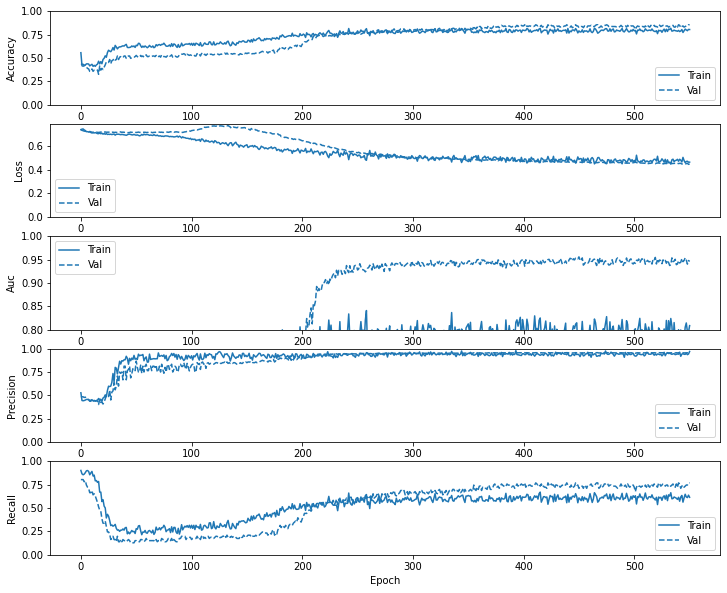

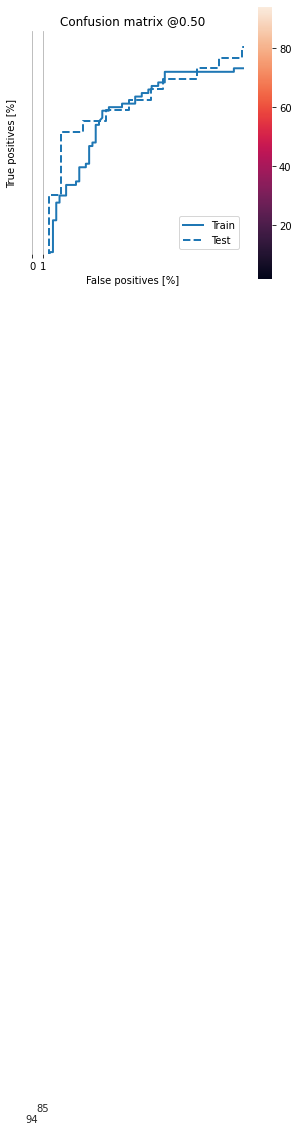

In [24]:
%%time
expId = 106
desc = str(expId) + " IQPEmbedding StronglyEntanglingLayers" 

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.templates.IQPEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))    
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

qlayer = qml.qnn.KerasLayer(qnode, {"weights": (n_layers, n_qubits, 3)}, output_dim=n_qubits)

model_106, history_106 = runTheExperiments(expId, desc)

# Save Data For Comparisons

In [25]:
#np.savetxt(results_folder + "n" + str(num_data) + "_train_labels.csv", train_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_labels.csv", val_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_labels.csv", test_labels, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_train_features.csv", train_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_val_features.csv", val_features, delimiter=",")
#np.savetxt(results_folder + "n" + str(num_data) + "_test_features.csv", test_features, delimiter=",")


# Experiments B - Classical Deep Learning

In [26]:
def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          2, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  model.summary()

  return model
  
 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 2)                 10        
_________________________________________________________________
dropout_7 (Dropout)          (None, 2)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 3         
Total params: 13
Trainable params: 13
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10000
13/13 [==============================] - 3s 85ms/step - loss: 0.7219 - tp: 137.5000 - fp: 16.0714 - tn: 270.4286 - fn: 144.8571 - accuracy: 0.7310 - precision: 0.8985 - recall: 0.5155 - auc: 0.7293 - val_loss: 0.6798 - val_tp: 34.0000 - val_fp: 11.0000 - val_tn: 62.0000 - val_fn: 52.0000 - val_accuracy: 0.6038 - val_precision: 0.7556 - val_recall: 0.3953 - val_auc: 0.5277

13/13 [==============================] - 0s 9ms/step - loss: 0.6285 - tp: 62.1429 - fp: 11.3571 - tn: 178.4286 - fn: 117.9286 - accuracy: 0.6543 - precision: 0.8502 - recall: 0.3342 - auc: 0.6193 - val_loss: 0.5557 - val_tp: 56.0000 - val_fp: 8.0000 - val_tn: 65.0000 - val_fn: 30.0000 - val_accuracy: 0.7610 - val_precision: 0.8750 - val_recall: 0.6512 - val_auc: 0.8202
Epoch 21/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.6123 - tp: 70.5000 - fp: 9.0000 - tn: 179.2143 - fn: 111.1429 - accuracy: 0.6852 - precision: 0.9026 - recall: 0.4016 - auc: 0.6502 - val_loss: 0.5526 - val_tp: 56.0000 - val_fp: 7.0000 - val_tn: 66.0000 - val_fn: 30.0000 - val_accuracy: 0.7673 - val_precision: 0.8889 - val_recall: 0.6512 - val_auc: 0.8214
Epoch 22/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.6104 - tp: 71.4286 - fp: 11.5000 - tn: 176.0714 - fn: 110.8571 - accuracy: 0.6622 - precision: 0.8699 - recall: 0.3830 - auc: 0.6580 - val_loss: 0.5500 - val_tp: 5

13/13 [==============================] - 0s 10ms/step - loss: 0.6091 - tp: 59.0714 - fp: 10.9286 - tn: 179.7857 - fn: 120.0714 - accuracy: 0.6333 - precision: 0.8598 - recall: 0.3159 - auc: 0.6379 - val_loss: 0.5134 - val_tp: 59.0000 - val_fp: 6.0000 - val_tn: 67.0000 - val_fn: 27.0000 - val_accuracy: 0.7925 - val_precision: 0.9077 - val_recall: 0.6860 - val_auc: 0.8596
Epoch 42/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5634 - tp: 71.0000 - fp: 8.7143 - tn: 188.8571 - fn: 101.2857 - accuracy: 0.7145 - precision: 0.8999 - recall: 0.4204 - auc: 0.7201 - val_loss: 0.5120 - val_tp: 59.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 27.0000 - val_accuracy: 0.7987 - val_precision: 0.9219 - val_recall: 0.6860 - val_auc: 0.8587
Epoch 43/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5910 - tp: 65.7857 - fp: 10.2857 - tn: 181.5000 - fn: 112.2857 - accuracy: 0.6634 - precision: 0.8666 - recall: 0.3504 - auc: 0.6852 - val_loss: 0.5110 - val_tp: 5

13/13 [==============================] - 0s 10ms/step - loss: 0.5836 - tp: 68.2857 - fp: 8.4286 - tn: 180.7143 - fn: 112.4286 - accuracy: 0.6723 - precision: 0.8888 - recall: 0.3720 - auc: 0.6929 - val_loss: 0.4968 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8676
Epoch 63/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.6028 - tp: 63.4286 - fp: 13.6429 - tn: 180.8571 - fn: 111.9286 - accuracy: 0.6584 - precision: 0.7919 - recall: 0.3628 - auc: 0.6757 - val_loss: 0.4963 - val_tp: 57.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 29.0000 - val_accuracy: 0.7862 - val_precision: 0.9194 - val_recall: 0.6628 - val_auc: 0.8690
Epoch 64/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.5579 - tp: 74.5000 - fp: 11.3571 - tn: 180.2857 - fn: 103.7143 - accuracy: 0.6857 - precision: 0.8761 - recall: 0.4121 - auc: 0.7283 - val_loss: 0.4953 - val_tp: 5

13/13 [==============================] - 0s 10ms/step - loss: 0.5726 - tp: 72.7857 - fp: 12.3571 - tn: 174.9286 - fn: 109.7857 - accuracy: 0.6662 - precision: 0.8706 - recall: 0.3806 - auc: 0.7171 - val_loss: 0.4787 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8773
Epoch 84/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5872 - tp: 65.1429 - fp: 10.6429 - tn: 182.3571 - fn: 111.7143 - accuracy: 0.6591 - precision: 0.8619 - recall: 0.3479 - auc: 0.6884 - val_loss: 0.4780 - val_tp: 58.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 28.0000 - val_accuracy: 0.7925 - val_precision: 0.9206 - val_recall: 0.6744 - val_auc: 0.8810
Epoch 85/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5342 - tp: 78.1429 - fp: 7.3571 - tn: 186.2857 - fn: 98.0714 - accuracy: 0.7250 - precision: 0.9222 - recall: 0.4546 - auc: 0.7475 - val_loss: 0.4773 - val_tp: 

13/13 [==============================] - 0s 12ms/step - loss: 0.5363 - tp: 67.5000 - fp: 5.4286 - tn: 189.4286 - fn: 107.5000 - accuracy: 0.6901 - precision: 0.9313 - recall: 0.3795 - auc: 0.7499 - val_loss: 0.4481 - val_tp: 60.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 26.0000 - val_accuracy: 0.8050 - val_precision: 0.9231 - val_recall: 0.6977 - val_auc: 0.9122
Epoch 105/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5187 - tp: 66.1429 - fp: 6.1429 - tn: 189.4286 - fn: 108.1429 - accuracy: 0.6998 - precision: 0.9219 - recall: 0.3771 - auc: 0.7719 - val_loss: 0.4459 - val_tp: 61.0000 - val_fp: 5.0000 - val_tn: 68.0000 - val_fn: 25.0000 - val_accuracy: 0.8113 - val_precision: 0.9242 - val_recall: 0.7093 - val_auc: 0.9103
Epoch 106/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.5369 - tp: 74.8571 - fp: 11.6429 - tn: 176.2143 - fn: 107.1429 - accuracy: 0.6758 - precision: 0.8678 - recall: 0.4182 - auc: 0.7580 - val_loss: 0.4449 - val_tp:

13/13 [==============================] - 0s 12ms/step - loss: 0.5248 - tp: 70.2143 - fp: 8.9286 - tn: 185.2143 - fn: 105.5000 - accuracy: 0.6852 - precision: 0.8623 - recall: 0.3935 - auc: 0.7712 - val_loss: 0.4194 - val_tp: 62.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 24.0000 - val_accuracy: 0.8302 - val_precision: 0.9538 - val_recall: 0.7209 - val_auc: 0.9307
Epoch 126/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.5285 - tp: 66.3571 - fp: 10.2143 - tn: 183.8571 - fn: 109.4286 - accuracy: 0.6723 - precision: 0.8554 - recall: 0.3661 - auc: 0.7713 - val_loss: 0.4180 - val_tp: 62.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 24.0000 - val_accuracy: 0.8239 - val_precision: 0.9394 - val_recall: 0.7209 - val_auc: 0.9314
Epoch 127/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.5239 - tp: 70.8571 - fp: 6.1429 - tn: 180.5714 - fn: 112.2857 - accuracy: 0.6821 - precision: 0.9373 - recall: 0.3987 - auc: 0.7832 - val_loss: 0.4160 - val_tp

13/13 [==============================] - 0s 9ms/step - loss: 0.4946 - tp: 69.8571 - fp: 7.0000 - tn: 180.8571 - fn: 112.1429 - accuracy: 0.6851 - precision: 0.9167 - recall: 0.3964 - auc: 0.7929 - val_loss: 0.3983 - val_tp: 64.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 22.0000 - val_accuracy: 0.8428 - val_precision: 0.9552 - val_recall: 0.7442 - val_auc: 0.9422
Epoch 147/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4720 - tp: 85.6429 - fp: 7.2857 - tn: 179.0000 - fn: 97.9286 - accuracy: 0.7163 - precision: 0.9283 - recall: 0.4717 - auc: 0.8224 - val_loss: 0.3976 - val_tp: 66.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 20.0000 - val_accuracy: 0.8553 - val_precision: 0.9565 - val_recall: 0.7674 - val_auc: 0.9423
Epoch 148/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.5006 - tp: 71.0714 - fp: 10.1429 - tn: 181.5000 - fn: 107.1429 - accuracy: 0.6886 - precision: 0.8726 - recall: 0.4152 - auc: 0.8039 - val_loss: 0.3971 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.4994 - tp: 69.9286 - fp: 10.2143 - tn: 181.9286 - fn: 107.7857 - accuracy: 0.6837 - precision: 0.8612 - recall: 0.3964 - auc: 0.7840 - val_loss: 0.3848 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9482
Epoch 168/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4655 - tp: 87.7857 - fp: 5.8571 - tn: 178.3571 - fn: 97.8571 - accuracy: 0.7119 - precision: 0.9442 - recall: 0.4776 - auc: 0.8301 - val_loss: 0.3837 - val_tp: 65.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 21.0000 - val_accuracy: 0.8491 - val_precision: 0.9559 - val_recall: 0.7558 - val_auc: 0.9483
Epoch 169/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4843 - tp: 73.9286 - fp: 6.2143 - tn: 184.7857 - fn: 104.9286 - accuracy: 0.6951 - precision: 0.9247 - recall: 0.4104 - auc: 0.8039 - val_loss: 0.3836 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4686 - tp: 72.4286 - fp: 4.7143 - tn: 187.5000 - fn: 105.2143 - accuracy: 0.7052 - precision: 0.9441 - recall: 0.4022 - auc: 0.8186 - val_loss: 0.3790 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9526
Epoch 189/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.4916 - tp: 75.8571 - fp: 10.5000 - tn: 180.1429 - fn: 103.3571 - accuracy: 0.6953 - precision: 0.8758 - recall: 0.4334 - auc: 0.7996 - val_loss: 0.3786 - val_tp: 67.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 19.0000 - val_accuracy: 0.8616 - val_precision: 0.9571 - val_recall: 0.7791 - val_auc: 0.9532
Epoch 190/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4781 - tp: 63.5000 - fp: 7.5000 - tn: 189.6429 - fn: 109.2143 - accuracy: 0.6857 - precision: 0.8891 - recall: 0.3690 - auc: 0.8131 - val_loss: 0.3780 - val_tp: 

13/13 [==============================] - 0s 9ms/step - loss: 0.4750 - tp: 74.6429 - fp: 6.5714 - tn: 180.7857 - fn: 107.8571 - accuracy: 0.6928 - precision: 0.9176 - recall: 0.4169 - auc: 0.8115 - val_loss: 0.3676 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9548
Epoch 210/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4876 - tp: 70.2857 - fp: 7.0000 - tn: 185.7143 - fn: 106.8571 - accuracy: 0.6914 - precision: 0.9089 - recall: 0.3837 - auc: 0.7934 - val_loss: 0.3673 - val_tp: 68.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 18.0000 - val_accuracy: 0.8679 - val_precision: 0.9577 - val_recall: 0.7907 - val_auc: 0.9541
Epoch 211/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.5002 - tp: 58.2143 - fp: 4.2143 - tn: 186.9286 - fn: 120.5000 - accuracy: 0.6588 - precision: 0.9385 - recall: 0.3151 - auc: 0.7805 - val_loss: 0.3664 - val_tp: 6

13/13 [==============================] - 0s 10ms/step - loss: 0.4552 - tp: 82.9286 - fp: 8.0000 - tn: 181.7857 - fn: 97.1429 - accuracy: 0.7134 - precision: 0.9028 - recall: 0.4610 - auc: 0.8272 - val_loss: 0.3600 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 231/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4497 - tp: 81.0000 - fp: 6.5000 - tn: 176.8571 - fn: 105.5000 - accuracy: 0.6943 - precision: 0.9288 - recall: 0.4522 - auc: 0.8279 - val_loss: 0.3591 - val_tp: 69.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 17.0000 - val_accuracy: 0.8742 - val_precision: 0.9583 - val_recall: 0.8023 - val_auc: 0.9568
Epoch 232/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4763 - tp: 70.2143 - fp: 7.2143 - tn: 190.0000 - fn: 102.4286 - accuracy: 0.7101 - precision: 0.9198 - recall: 0.4144 - auc: 0.8093 - val_loss: 0.3577 - val_tp: 6

13/13 [==============================] - 0s 9ms/step - loss: 0.4554 - tp: 82.6429 - fp: 5.4286 - tn: 183.5714 - fn: 98.2143 - accuracy: 0.7192 - precision: 0.9416 - recall: 0.4634 - auc: 0.8269 - val_loss: 0.3507 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9530
Epoch 252/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4639 - tp: 73.4286 - fp: 8.0714 - tn: 188.2857 - fn: 100.0714 - accuracy: 0.7144 - precision: 0.8893 - recall: 0.4311 - auc: 0.8182 - val_loss: 0.3504 - val_tp: 73.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 13.0000 - val_accuracy: 0.8994 - val_precision: 0.9605 - val_recall: 0.8488 - val_auc: 0.9529
Epoch 253/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4620 - tp: 72.5714 - fp: 5.9286 - tn: 187.8571 - fn: 103.5000 - accuracy: 0.7111 - precision: 0.9255 - recall: 0.4182 - auc: 0.8165 - val_loss: 0.3504 - val_tp: 73.

13/13 [==============================] - 0s 9ms/step - loss: 0.4771 - tp: 82.6429 - fp: 7.4286 - tn: 182.1429 - fn: 97.6429 - accuracy: 0.7091 - precision: 0.9176 - recall: 0.4443 - auc: 0.8156 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9529
Epoch 273/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4725 - tp: 66.2857 - fp: 6.8571 - tn: 189.6429 - fn: 107.0714 - accuracy: 0.6931 - precision: 0.9324 - recall: 0.3728 - auc: 0.8091 - val_loss: 0.3440 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9534
Epoch 274/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4407 - tp: 82.9286 - fp: 6.0000 - tn: 192.7143 - fn: 88.2143 - accuracy: 0.7600 - precision: 0.9203 - recall: 0.4972 - auc: 0.8366 - val_loss: 0.3439 - val_tp: 74.

13/13 [==============================] - 0s 11ms/step - loss: 0.4734 - tp: 72.0714 - fp: 7.3571 - tn: 185.3571 - fn: 105.0714 - accuracy: 0.6989 - precision: 0.8953 - recall: 0.4087 - auc: 0.7985 - val_loss: 0.3422 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9535
Epoch 294/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4813 - tp: 66.0714 - fp: 6.6429 - tn: 186.9286 - fn: 110.2143 - accuracy: 0.6750 - precision: 0.9248 - recall: 0.3662 - auc: 0.7944 - val_loss: 0.3424 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9536
Epoch 295/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4533 - tp: 82.2857 - fp: 6.5714 - tn: 182.5714 - fn: 98.4286 - accuracy: 0.7241 - precision: 0.9298 - recall: 0.4674 - auc: 0.8258 - val_loss: 0.3421 - val_tp: 7

13/13 [==============================] - 0s 11ms/step - loss: 0.4348 - tp: 77.8571 - fp: 5.2857 - tn: 191.4286 - fn: 95.2857 - accuracy: 0.7360 - precision: 0.9454 - recall: 0.4551 - auc: 0.8469 - val_loss: 0.3363 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9560
Epoch 315/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4428 - tp: 76.8571 - fp: 5.9286 - tn: 187.5000 - fn: 99.5714 - accuracy: 0.7265 - precision: 0.9419 - recall: 0.4517 - auc: 0.8384 - val_loss: 0.3358 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9564
Epoch 316/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4632 - tp: 81.9286 - fp: 5.2857 - tn: 185.1429 - fn: 97.5000 - accuracy: 0.7108 - precision: 0.9416 - recall: 0.4441 - auc: 0.8231 - val_loss: 0.3357 - val_tp: 74.

13/13 [==============================] - 0s 10ms/step - loss: 0.4607 - tp: 85.1429 - fp: 9.7143 - tn: 177.6429 - fn: 97.3571 - accuracy: 0.7120 - precision: 0.8818 - recall: 0.4705 - auc: 0.8114 - val_loss: 0.3296 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9556
Epoch 336/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4805 - tp: 79.0714 - fp: 6.2143 - tn: 182.6429 - fn: 101.9286 - accuracy: 0.7102 - precision: 0.9338 - recall: 0.4484 - auc: 0.8050 - val_loss: 0.3302 - val_tp: 74.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 12.0000 - val_accuracy: 0.9057 - val_precision: 0.9610 - val_recall: 0.8605 - val_auc: 0.9552
Epoch 337/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.4600 - tp: 76.8571 - fp: 6.1429 - tn: 193.7857 - fn: 93.0714 - accuracy: 0.7271 - precision: 0.9071 - recall: 0.4415 - auc: 0.8155 - val_loss: 0.3296 - val_tp: 74

13/13 [==============================] - 0s 10ms/step - loss: 0.4648 - tp: 66.4286 - fp: 7.6429 - tn: 192.4286 - fn: 103.3571 - accuracy: 0.7106 - precision: 0.8870 - recall: 0.3799 - auc: 0.8083 - val_loss: 0.3313 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9553
Epoch 357/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4500 - tp: 74.7857 - fp: 4.6429 - tn: 191.2143 - fn: 99.2143 - accuracy: 0.7193 - precision: 0.9545 - recall: 0.4220 - auc: 0.8296 - val_loss: 0.3294 - val_tp: 75.0000 - val_fp: 3.0000 - val_tn: 70.0000 - val_fn: 11.0000 - val_accuracy: 0.9119 - val_precision: 0.9615 - val_recall: 0.8721 - val_auc: 0.9545
Epoch 358/10000
13/13 [==============================] - 0s 10ms/step - loss: 0.4764 - tp: 80.7143 - fp: 3.0714 - tn: 188.0000 - fn: 98.0714 - accuracy: 0.7198 - precision: 0.9528 - recall: 0.4403 - auc: 0.8034 - val_loss: 0.3284 - val_tp: 75

13/13 [==============================] - 0s 10ms/step - loss: 0.4418 - tp: 78.9286 - fp: 5.7857 - tn: 194.1429 - fn: 91.0000 - accuracy: 0.7465 - precision: 0.9343 - recall: 0.4646 - auc: 0.8287 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 378/10000
13/13 [==============================] - 0s 12ms/step - loss: 0.4340 - tp: 83.1429 - fp: 8.7143 - tn: 185.9286 - fn: 92.0714 - accuracy: 0.7351 - precision: 0.9077 - recall: 0.4867 - auc: 0.8430 - val_loss: 0.3259 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9542
Epoch 379/10000
13/13 [==============================] - 0s 9ms/step - loss: 0.4420 - tp: 77.7857 - fp: 4.7143 - tn: 187.4286 - fn: 99.9286 - accuracy: 0.7183 - precision: 0.9529 - recall: 0.4412 - auc: 0.8356 - val_loss: 0.3257 - val_tp: 75.

13/13 [==============================] - 0s 12ms/step - loss: 0.4954 - tp: 74.0000 - fp: 6.5714 - tn: 182.1429 - fn: 107.1429 - accuracy: 0.6870 - precision: 0.9211 - recall: 0.3954 - auc: 0.7932 - val_loss: 0.3263 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9540
Epoch 399/10000
13/13 [==============================] - 0s 11ms/step - loss: 0.4880 - tp: 83.1429 - fp: 5.3571 - tn: 182.6429 - fn: 98.7143 - accuracy: 0.7101 - precision: 0.9335 - recall: 0.4624 - auc: 0.7927 - val_loss: 0.3267 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Epoch 400/10000
13/13 [==============================] - 0s 8ms/step - loss: 0.4478 - tp: 82.6429 - fp: 5.0714 - tn: 185.1429 - fn: 97.0000 - accuracy: 0.7124 - precision: 0.9433 - recall: 0.4515 - auc: 0.8407 - val_loss: 0.3253 - val_tp: 75

13/13 [==============================] - 0s 10ms/step - loss: 0.4512 - tp: 79.8571 - fp: 5.2857 - tn: 187.7143 - fn: 97.0000 - accuracy: 0.7160 - precision: 0.9286 - recall: 0.4512 - auc: 0.8264 - val_loss: 0.3215 - val_tp: 75.0000 - val_fp: 4.0000 - val_tn: 69.0000 - val_fn: 11.0000 - val_accuracy: 0.9057 - val_precision: 0.9494 - val_recall: 0.8721 - val_auc: 0.9536
Restoring model weights from the end of the best epoch.
Epoch 00419: early stopping
loss :  0.28389766812324524
tp :  95.0
fp :  4.0
tn :  92.0
fn :  8.0
accuracy :  0.9396985173225403
precision :  0.9595959782600403
recall :  0.9223300814628601
auc :  0.978762149810791

Legitimate Domain Name Detected (True Negatives):  92
Legitimate Domain Name Incorrectly Detected as Botnet DGA (False Positives):  4
Botnet DGA Missed (False Negatives):  8
Botnet DGA Detected (True Positives):  95
Total Botnet DGAs:  103
CPU times: user 1min 19s, sys: 3.59 s, total: 1min 23s
Wall time: 1min 14s


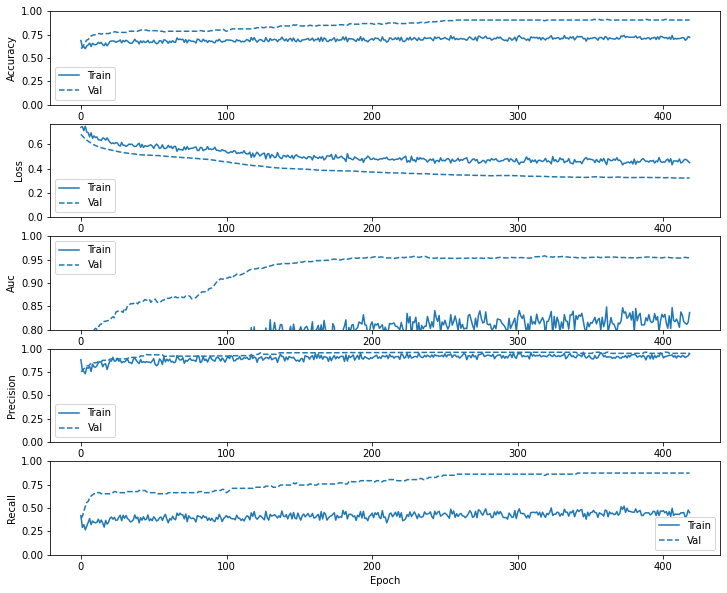

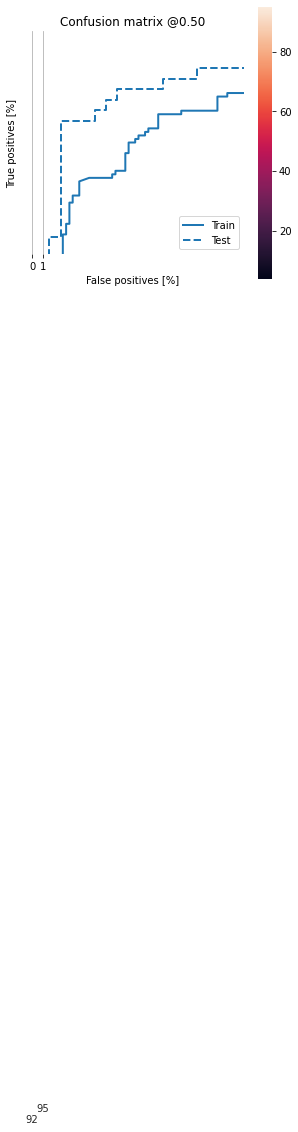

In [27]:
%%time
expId = 201
desc = str(expId) + " Classical Deep Learning" 

model_201, history_201 = runTheExperiments(expId, desc)


In [28]:
f.write("19_BotnetDga_Benchmarks - CPU n100 1layer - Device Noise Model ibmq_athens - qiskit.aer - seed 123")
f.flush()